# Import libraries

In [162]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib as mplt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
from sklearn.utils import parallel_backend
from sklearn.decomposition import PCA
import copy
pd.set_option("display.max_columns", None)
from datetime import datetime
import re
plt.rcParams["figure.figsize"] = [20, 5]

import sklearn
sklearn.set_config(display='diagram')

# Read data

In [163]:
df = pd.read_csv('https://github.com/ZRen-Flindelwald/RSM_8413_Project1/blob/main/COVID-19BehaviorData_CAN_USA.csv?raw=True', 
                 na_values=[' '])

In [164]:
df

,Index,RecordNo,endtime,qweek,i1_health,i2_health,i7a_health,i3_health,i4_health,i5_health_1,i5_health_2,i5_health_3,i5_health_4,i5_health_5,i5_health_99,i5a_health,i6_health,i7b_health,i8_health,i9_health,i10_health,i11_health,i12_health_1,i12_health_2,i12_health_3,i12_health_4,i12_health_5,i12_health_6,i12_health_7,i12_health_8,i12_health_9,i12_health_10,i12_health_11,i12_health_12,i12_health_13,i12_health_14,i12_health_15,i12_health_16,i12_health_17,i12_health_18,i12_health_19,i12_health_20,i13_health,i14_health_1,i14_health_2,i14_health_3,i14_health_4,i14_health_5,i14_health_6,i14_health_7,i14_health_8,i14_health_9,i14_health_10,i14_health_96,i14_health_98,i14_health_99,i14_health_other,d1_health_1,d1_health_2,d1_health_3,d1_health_4,d1_health_5,d1_health_6,d1_health_7,d1_health_8,d1_health_9,d1_health_10,d1_health_11,d1_health_12,d1_health_13,d1_health_98,d1_health_99,weight,gender,age,region_state,household_size,household_children,employment_status
0,0,CAN0,02/04/2020 08:25,week 1,0,1,1,"No, I have not","No, they have not",No,No,No,No,No,Yes,NaN,NaN,NaN,NaN,Yes,Very easy,Very willing,Not at all,Always,Frequently,Always,Always,Frequently,Always,Always,NaN,NaN,Always,Always,Always,Always,Always,Frequently,Always,Always,Frequently,Always,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,__NA__,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,1.036370,Male,73,British Columbia / Colombie Britanique,1,0,Retired
1,1,CAN1,02/04/2020 08:34,week 1,0,6,0,"No, I have not","No, they have not",Yes,No,No,No,No,No,No,Frequently,No,No,Yes,Somewhat difficult,Somewhat willing,Not at all,Always,Frequently,Always,Not at all,Frequently,Always,Always,NaN,NaN,Always,Frequently,Always,Always,Frequently,Sometimes,Not at all,Not at all,Sometimes,Always,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,__NA__,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,1.016961,Female,37,British Columbia / Colombie Britanique,1,0,Unemployed
2,2,CAN2,02/04/2020 08:44,week 1,6,1,0,"No, I have not","No, they have not",No,No,No,No,Yes,No,No,Frequently,No,No,Yes,Somewhat easy,Very willing,Frequently,Frequently,Sometimes,Always,Always,Always,Frequently,Always,Frequently,Always,Always,Frequently,Always,Always,Always,Frequently,Not at all,Always,Rarely,Frequently,10,No,No,Yes,No,No,No,No,No,No,No,No,No,No,__NA__,No,Yes,No,No,No,No,No,No,No,No,No,Yes,No,No,No,1.003516,Male,25,Ontario,8 or more,2,Full time employment
3,3,CAN3,02/04/2020 08:44,week 1,1,1,1,"No, I have not","No, they have not",No,No,No,No,No,Yes,NaN,NaN,NaN,NaN,Yes,Very easy,Very willing,Frequently,Frequently,Always,Always,Always,Always,Always,Always,NaN,NaN,Always,Always,Always,Always,Always,Always,Not at all,Always,Frequently,Always,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,__NA__,No,No,No,No,No,Yes,No,No,Yes,No,No,No,No,No,No,1.002949,Male,66,Ontario,2,0,Retired
4,4,CAN4,02/04/2020 09:00,week 1,1,3,1,"No, I have not","No, they have not",No,No,No,No,No,Yes,NaN,NaN,NaN,NaN,Yes,Somewhat easy,Very willing,Not at all,Sometimes,Rarely,Always,Always,Frequently,Always,Always,NaN,NaN,Always,Always,Always,Always,Always,Frequently,Not at all,Not at all,Not at all,Frequently,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,__NA__,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,1.028216,Female,25,British Columbia / Colombie Britanique,2,0,Unemployed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28820,28820,USA16977,29/09/2020 04:57,week 16,2,1,1,"No, I have not","No, they have not",No,No,No,No,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Always,Always,Always,Always,Always,Frequently,Frequently,Always,Always,Always,Always,Always,Always,Always,Always,Frequently,Not at all,Not at all,Frequently,Always,9,No,No,No,No,No,No,No,No,No,No,No,No,Y

# Data understanding 


## Check data types

In [165]:
# most of the data types are strings, need to think how to convert to numbers
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28825 entries, 0 to 28824
Data columns (total 79 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Index               28825 non-null  int64  
 1   RecordNo            28825 non-null  object 
 2   endtime             28825 non-null  object 
 3   qweek               28825 non-null  object 
 4   i1_health           28825 non-null  int64  
 5   i2_health           28825 non-null  int64  
 6   i7a_health          28825 non-null  int64  
 7   i3_health           28420 non-null  object 
 8   i4_health           27968 non-null  object 
 9   i5_health_1         28106 non-null  object 
 10  i5_health_2         28106 non-null  object 
 11  i5_health_3         28106 non-null  object 
 12  i5_health_4         28106 non-null  object 
 13  i5_health_5         28106 non-null  object 
 14  i5_health_99        28106 non-null  object 
 15  i5a_health          2606 non-null   object 
 16  i6_h

## Missing values

In [166]:
# % of missing in each column
df.isna().sum()[df.isna().sum() != 0] / df.shape[0] * 100

i3_health         1.405030
i4_health         2.973114
i5_health_1       2.494363
i5_health_2       2.494363
i5_health_3       2.494363
i5_health_4       2.494363
i5_health_5       2.494363
i5_health_99      2.494363
i5a_health       90.959237
i6_health        90.959237
i7b_health       91.965308
i8_health        92.138768
i9_health         6.699046
i10_health        6.699046
i11_health        6.699046
i12_health_9     57.814397
i12_health_10    64.801388
i14_health_1     57.814397
i14_health_2     57.814397
i14_health_3     57.814397
i14_health_4     57.814397
i14_health_5     57.814397
i14_health_6     57.814397
i14_health_7     57.814397
i14_health_8     57.814397
i14_health_9     57.814397
i14_health_10    57.814397
i14_health_96    57.814397
i14_health_98    57.814397
i14_health_99    57.814397
d1_health_1       9.734605
d1_health_2       9.734605
d1_health_3       9.734605
d1_health_4       9.734605
d1_health_5       9.734605
d1_health_6       9.734605
d1_health_7       9.734605
d

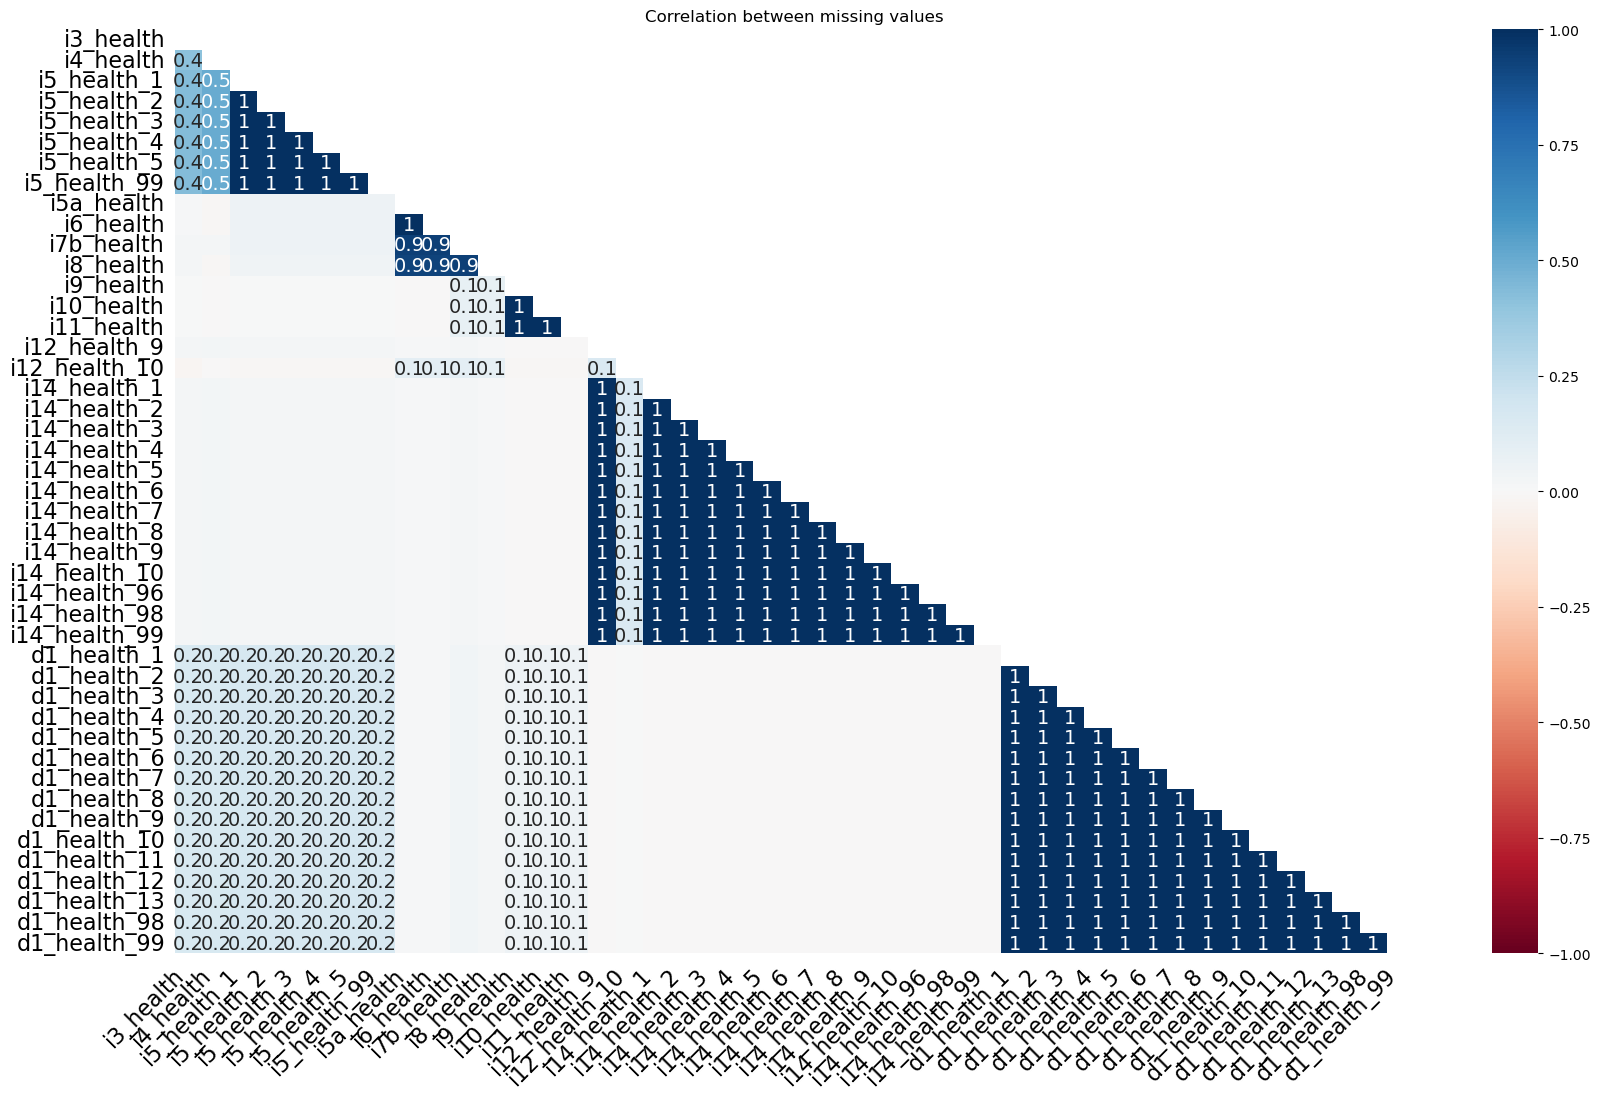

In [167]:
# seems like missingness is not correlated with variables outside the same group 
msno.heatmap(df)
plt.title("Correlation between missing values")
plt.show()

In [168]:
df.describe()

,Index,i1_health,i2_health,i7a_health,i13_health,weight,age
count,28825.000000,28825.000000,28825.000000,28825.000000,28825.000000,28825.000000,28825.000000
mean,14412.000000,2.939497,10.891587,1.328257,11.602116,1.000000,48.621405
std,8321.205091,24.333711,58.419991,3.567293,31.191026,0.364100,17.471780
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.069373,18.000000
25%,7206.000000,1.000000,0.000000,0.000000,5.000000,0.857844,33.000000
50%,14412.000000,1.000000,2.000000,1.000000,8.000000,0.983510,50.000000
75%,21618.000000,3.000000,6.000000,2.000000,12.000000,1.086118,63.000000
max,28824.000000,1000.000000,1000.000000,100.000000,1000.000000,15.646664,99.000000


## Details of each column

In [169]:
df.groupby('i3_health').size()

i3_health
No, I have not                                               26284
Yes, and I have not received my results from the test yet      341
Yes, and I tested negative                                    1515
Yes, and I tested positive                                     280
dtype: int64

In [170]:
# drop i4_health: unable to action, too many didn't test
df.groupby('i4_health').size()

i4_health
No, they have not                                                  24392
Not sure                                                            1317
Yes, and they have not received their results from the test yet      396
Yes, and they tested negative                                       1644
Yes, and they tested positive                                        219
dtype: int64

<AxesSubplot:xlabel='i3_health'>

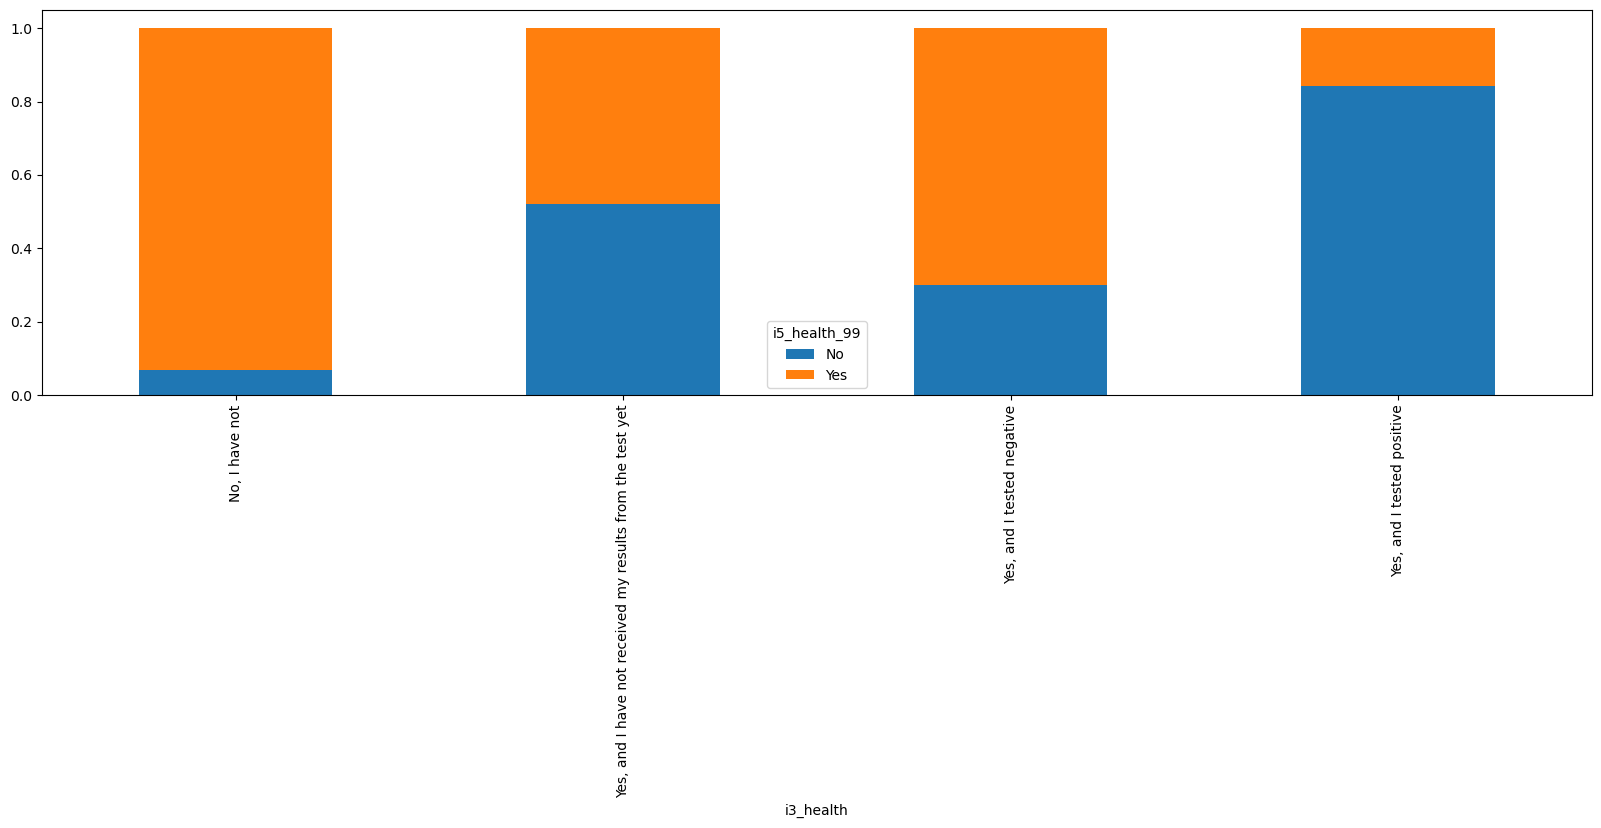

In [171]:
df_crosstab = pd.crosstab(df["i5_health_99"], df["i3_health"], margins = False)
df_crosstab_t = df_crosstab.transpose()
df_crosstab_norm = df_crosstab_t.div(df_crosstab_t.sum(axis=1), axis=0)
df_crosstab_norm.plot(kind = 'bar', stacked = True)

In [172]:
df.describe()
# drop weight as it doesn't seem real: maximum is 15kg?

,Index,i1_health,i2_health,i7a_health,i13_health,weight,age
count,28825.000000,28825.000000,28825.000000,28825.000000,28825.000000,28825.000000,28825.000000
mean,14412.000000,2.939497,10.891587,1.328257,11.602116,1.000000,48.621405
std,8321.205091,24.333711,58.419991,3.567293,31.191026,0.364100,17.471780
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.069373,18.000000
25%,7206.000000,1.000000,0.000000,0.000000,5.000000,0.857844,33.000000
50%,14412.000000,1.000000,2.000000,1.000000,8.000000,0.983510,50.000000
75%,21618.000000,3.000000,6.000000,2.000000,12.000000,1.086118,63.000000
max,28824.000000,1000.000000,1000.000000,100.000000,1000.000000,15.646664,99.000000


In [173]:
# age: numeric -> standardize
# gender: one-hot encoding
df.groupby("gender").size()

gender
Female    15703
Male      13122
dtype: int64

In [174]:
# household_size, household_children: to numeric, don't know or prefer not to say to NA
df.groupby("household_size").size()

household_size
1                    5357
2                    9898
3                    4921
4                    4001
5                    2099
6                     899
7                     382
8 or more             284
Don't know            341
Prefer not to say     643
dtype: int64

In [175]:
# drop region_state as one-hot encoding 64 states will create a very sparse matrix
# instead do the split between CAN and US using the RecordNo column, # country -> categorical
# employment_status: one-hot encoding
df.groupby("region_state").size()

region_state
Alabama           307
Alaska             71
Alberta          1329
Arizona           419
Arkansas          146
                 ... 
Washington        385
West Virginia     112
Wisconsin         319
Wyoming            39
Yukon              24
Length: 64, dtype: int64

In [176]:
df.columns

Index(['Index', 'RecordNo', 'endtime', 'qweek', 'i1_health', 'i2_health',
       'i7a_health', 'i3_health', 'i4_health', 'i5_health_1', 'i5_health_2',
       'i5_health_3', 'i5_health_4', 'i5_health_5', 'i5_health_99',
       'i5a_health', 'i6_health', 'i7b_health', 'i8_health', 'i9_health',
       'i10_health', 'i11_health', 'i12_health_1', 'i12_health_2',
       'i12_health_3', 'i12_health_4', 'i12_health_5', 'i12_health_6',
       'i12_health_7', 'i12_health_8', 'i12_health_9', 'i12_health_10',
       'i12_health_11', 'i12_health_12', 'i12_health_13', 'i12_health_14',
       'i12_health_15', 'i12_health_16', 'i12_health_17', 'i12_health_18',
       'i12_health_19', 'i12_health_20', 'i13_health', 'i14_health_1',
       'i14_health_2', 'i14_health_3', 'i14_health_4', 'i14_health_5',
       'i14_health_6', 'i14_health_7', 'i14_health_8', 'i14_health_9',
       'i14_health_10', 'i14_health_96', 'i14_health_98', 'i14_health_99',
       'i14_health_other', 'd1_health_1', 'd1_health_2', 'd

# Data preparation

In [177]:
# # Dataframe used for plotting
plot_df = df.copy(deep=True)
#plot_df.info()

In [178]:
# new column country = CAN or US from RecordNo
df['country'] = df.RecordNo.str.split('[0-9]+', expand=True)[0].astype('category')

# drop Index, RecordNo, endtime, qweek, i3_health, i4_health
# drop i5_health_1, i5_health_2, i5_health_3, i5_health_4, i5_health_5
# drop i14_health_other, weight
# drop region_state as one-hot encoding 64 states will create a sparse matrix (replaced with country column)
df.drop(columns = ["Index", "RecordNo", "endtime", "qweek", "i4_health",
                   "i5_health_1", "i5_health_2", "i5_health_3", "i5_health_4", "i5_health_5",
                   "i14_health_other", "weight", "region_state"], inplace = True)

# drop and set up flag variable for missingness in i5a_health, i6_health, i7b_health, i8_health 
df[["i5a_health_missing", "i6_health_missing", "i7b_health_missing", "i8_health_missing"]] = df[["i5a_health", "i6_health", "i7b_health", "i8_health"]].isna().astype(int)
df.drop(columns = ["i5a_health", "i6_health", "i7b_health", "i8_health"], inplace = True)

# categorical
# country -> categorical
df.country = df.country.astype('category')
# gender: one-hot encoding
df.gender = df.gender.astype('category')
# employment_status: one-hot encoding
df.employment_status = df.employment_status.astype('category')

# numeric
# i13_health -> numeric -> standardize
# age: numeric -> standardize
# i1_health, i2_health, i7a_health (numeric -> standardize)
# keep i5_health_99 as target variable (flip the sign such that 0 = no symptoms and 1 = any symptoms)
df.i5_health_99 = df.i5_health_99.map({"Yes": 0, "No": 1})
# i9_health -> dummy with not sure = NA
df.i9_health = df.i9_health.map({"Yes": 1, "No": 0, "Not sure": np.nan})
# i14_health_1, _2, ..., _99 -> dummy (_98 interpreted as flag variable for missingess)
for col1 in df.columns[["i14_health_" in x for x in df.columns]]:
  df[col1] = df[col1].map({"Yes": 1, "No": 0})
# d1_health_1, _2, ..., _99 -> dummy (_98 interpreted as flag variable for missingess)
for col2 in df.columns[["d1_health_" in x for x in df.columns]]:
  df[col2] = df[col2].map({"Yes": 1, "No": 0})
# i10_health, i11_health -> likert scale with not sure = NA
df.i10_health = df.i10_health.map({
    "Very difficult": -2,
    "Somewhat difficult": -1,
    "Neither easy nor difficult": -0,
    "Somewhat easy": 1,
    "Very easy": 2,
    "Not sure": np.nan,
})
df.i11_health = df.i11_health.map({
    "Very unwilling": -2,
    "Somewhat unwilling": -1,
    "Neither willing nor unwilling": -0,
    "Somewhat willing": 1,
    "Very willing": 2,
    "Not sure": np.nan,
})
# i12_health_1, _2, ..., _20 -> likert scale
for col3 in df.columns[["i12_health_" in x for x in df.columns]]:
  df[col3] = df[col3].map({
      "Always": 2,
      "Frequently": 1,
      "Sometimes": 0,
      "Rarely": -1,
      "Not at all": -2,
  })
# household_size, household_children: numeric, don't know or prefer not to say to NA
df.household_size = df.household_size.map({
    "1": 1, "2": 2, "3": 3, "4": 4, "5": 5, "6": 6, "7": 7,
    "8 or more": 8, 
    "Don't know": np.nan,
    "Prefer not to say": np.nan
})
df.household_children = df.household_children.map({
    "0": 0, "1": 1, "2": 2, "3": 3, "4": 4,
    "5 or more": 5, 
    "Don't know": np.nan,
    "Prefer not to say": np.nan
})



In [179]:
df.groupby("i5_health_99").size()

i5_health_99
0.0    25502
1.0     2604
dtype: int64

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28825 entries, 0 to 28824
Data columns (total 67 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   i1_health           28825 non-null  int64   
 1   i2_health           28825 non-null  int64   
 2   i7a_health          28825 non-null  int64   
 3   i3_health           28420 non-null  object  
 4   i5_health_99        28106 non-null  float64 
 5   i9_health           24336 non-null  float64 
 6   i10_health          25701 non-null  float64 
 7   i11_health          25684 non-null  float64 
 8   i12_health_1        28825 non-null  int64   
 9   i12_health_2        28825 non-null  int64   
 10  i12_health_3        28825 non-null  int64   
 11  i12_health_4        28825 non-null  int64   
 12  i12_health_5        28825 non-null  int64   
 13  i12_health_6        28825 non-null  int64   
 14  i12_health_7        28825 non-null  int64   
 15  i12_health_8        28825 non-null  

# Data preparation pipeline

In [181]:
df['covid'] = np.nan
df.loc[df['i3_health'] == "Yes, and I tested positive", "covid"] = 1
df.loc[df['i3_health'] == "Yes, and I tested negative", "covid"] = 0
df.loc[((df['i3_health'] == "No, I have not") | (df['i3_health'] == "Yes, and I have not received my results from the test yet")) & (df["i5_health_99"] == 0), "covid"] = 0
df.loc[((df['i3_health'] == "No, I have not") | (df['i3_health'] == "Yes, and I have not received my results from the test yet")) & (df["i5_health_99"] == 1), "covid"] = 1
df.loc[(df['i3_health'].isna()) & (df["i5_health_99"] == 1), "covid"] = 1
df.loc[(df['i3_health'].isna()) & (df["i5_health_99"] == 0), "covid"] = 0

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28825 entries, 0 to 28824
Data columns (total 68 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   i1_health           28825 non-null  int64   
 1   i2_health           28825 non-null  int64   
 2   i7a_health          28825 non-null  int64   
 3   i3_health           28420 non-null  object  
 4   i5_health_99        28106 non-null  float64 
 5   i9_health           24336 non-null  float64 
 6   i10_health          25701 non-null  float64 
 7   i11_health          25684 non-null  float64 
 8   i12_health_1        28825 non-null  int64   
 9   i12_health_2        28825 non-null  int64   
 10  i12_health_3        28825 non-null  int64   
 11  i12_health_4        28825 non-null  int64   
 12  i12_health_5        28825 non-null  int64   
 13  i12_health_6        28825 non-null  int64   
 14  i12_health_7        28825 non-null  int64   
 15  i12_health_8        28825 non-null  

In [183]:
# drop na on target variable first
full_df = df.dropna(subset = ['covid'])
full_df.drop(["i3_health", "i5_health_99"], axis = 1, inplace = True)
# train test split
train_set, test_set = train_test_split(full_df, test_size = 0.2)

C:\Users\r3080\AppData\Local\Temp\ipykernel_2180\1924305208.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df.drop(["i3_health", "i5_health_99"], axis = 1, inplace = True)


In [184]:
target_variable = 'covid'
X_train = train_set.drop(columns = [target_variable]).reset_index(drop = True).copy(deep = True)
y_train = train_set[target_variable].reset_index(drop=True)
X_test = test_set.drop(columns = [target_variable]).reset_index(drop = True).copy(deep = True)
y_test = test_set[target_variable].reset_index(drop=True)

In [185]:
num_pipeline = make_pipeline(
    SimpleImputer(strategy = 'median'),
    MinMaxScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    OneHotEncoder()
)

data_preparation = make_pipeline(
    ColumnTransformer([
        ("num", num_pipeline, make_column_selector(dtype_include=np.number)),
        ("cat", cat_pipeline, make_column_selector(dtype_include='category')),
    ], 
    # drop remaining columns if any
    remainder="drop",
    # drop column prefix
    verbose_feature_names_out = False, 
    ),

    PCA(n_components=0.95)
    
)

In [186]:
data_preparation

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000129809A44F0>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000129865B54C0>)],
                                   verbose_feature_names_out=False)),
                ('pca', PCA(n_components=0.95))])

In [187]:
X_trans = data_preparation.fit_transform(X_train)
#X_train = pd.DataFrame(X_trans, columns= columns)

In [188]:
X_trans

array([[ 9.28700502e-01, -1.03534742e+00, -1.41430437e-01, ...,
        -4.22443370e-01,  5.78801961e-01,  2.78746486e-01],
       [ 1.27285886e+00, -7.74981627e-01, -2.68909404e-01, ...,
         1.62402179e-01, -1.52508874e-01, -8.80995009e-02],
       [-6.57405801e-01, -6.77591723e-01,  1.08964548e+00, ...,
        -1.27276964e-02, -1.08944256e-01, -4.35875986e-04],
       ...,
       [-4.05209410e-01,  4.36661813e-01,  8.19093160e-01, ...,
         1.77206174e-01,  9.08852018e-03,  3.35878960e-02],
       [-1.10385174e+00, -1.20664172e+00, -7.46690520e-01, ...,
         1.01129356e-02,  6.89907132e-02,  4.08397194e-02],
       [ 2.01104751e+00,  3.76901993e-01, -5.01150053e-01, ...,
         5.71735724e-03,  2.76574734e-01,  9.68241012e-02]])

# EDA

In [189]:
# new column country = CAN or US from RecordNo
plot_df['country'] = plot_df.RecordNo.str.split('[0-9]+', expand=True)[0].astype('category')

# drop Index, RecordNo, endtime, qweek, i3_health, i4_health
# drop i5_health_1, i5_health_2, i5_health_3, i5_health_4, i5_health_5
# drop i14_health_other, weight
# drop region_state as one-hot encoding 64 states will create a very sparse matrix (replaced with country column)
plot_df.drop(columns = ["Index", "RecordNo", "endtime", "qweek", "i4_health",
                   "i5_health_1", "i5_health_2", "i5_health_3", "i5_health_4", "i5_health_5",
                   "i14_health_other", "weight", "region_state"], inplace = True)

# set up flag variable for missingness in i5a_health, i6_health, i7b_health, i8_health 
# drop them
plot_df[["i5a_health_missing", "i6_health_missing", "i7b_health_missing", "i8_health_missing"]] = plot_df[["i5a_health", "i6_health", "i7b_health", "i8_health"]].isna().astype(int)
plot_df.drop(columns = ["i5a_health", "i6_health", "i7b_health", "i8_health"], inplace = True)

# categorical
# country -> categorical
plot_df.country = plot_df.country.astype('category')
# gender: one-hot encoding
plot_df.gender = plot_df.gender.astype('category')
# employment_status: one-hot encoding
plot_df.employment_status = plot_df.employment_status.astype('category')

# plot_df.household_size = plot_df.household_size.map({"8 or more": 8, "Don't know": np.nan, 'Prefer not to say': np.nan})
# plot_df.household_children = plot_df.household_children.map({"5 or more": 5, "Don't know": np.nan, 'Prefer not to say': np.nan})


plot_df['Risk of Covid Positive'] = np.nan
plot_df.loc[plot_df['i3_health'] == "Yes, and I tested positive", "Risk of Covid Positive"] = 'Yes'
plot_df.loc[plot_df['i3_health'] == "Yes, and I tested negative", "Risk of Covid Positive"] = 'No'
plot_df.loc[((plot_df['i3_health'] == "No, I have not") | (plot_df['i3_health'] == "Yes, and I have not received my results from the test yet")) & (plot_df["i5_health_99"] == 'Yes'), "Risk of Covid Positive"] = 'No'
plot_df.loc[((plot_df['i3_health'] == "No, I have not") | (plot_df['i3_health'] == "Yes, and I have not received my results from the test yet")) & (plot_df["i5_health_99"] == 'No'), "Risk of Covid Positive"] = 'Yes'
plot_df.loc[(plot_df['i3_health'].isna()) & (plot_df["i5_health_99"] == 'No'), "Risk of Covid Positive"] = 'Yes'
plot_df.loc[(plot_df['i3_health'].isna()) & (plot_df["i5_health_99"] == 'Yes'), "Risk of Covid Positive"] = 'No'


In [190]:
plot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28825 entries, 0 to 28824
Data columns (total 68 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   i1_health               28825 non-null  int64   
 1   i2_health               28825 non-null  int64   
 2   i7a_health              28825 non-null  int64   
 3   i3_health               28420 non-null  object  
 4   i5_health_99            28106 non-null  object  
 5   i9_health               26894 non-null  object  
 6   i10_health              26894 non-null  object  
 7   i11_health              26894 non-null  object  
 8   i12_health_1            28825 non-null  object  
 9   i12_health_2            28825 non-null  object  
 10  i12_health_3            28825 non-null  object  
 11  i12_health_4            28825 non-null  object  
 12  i12_health_5            28825 non-null  object  
 13  i12_health_6            28825 non-null  object  
 14  i12_health_7          

In [191]:
# drop na on target variable first
plot_df = plot_df.dropna(subset = ['Risk of Covid Positive'])
plot_df.drop(["i3_health", "i5_health_99"], axis = 1, inplace = True)
# household_size, household_children: numeric, don't know or prefer not to say to NA
plot_df.household_children = plot_df.household_children.map({
    "0": 0, "1": 1, "2": 2, "3": 3, "4": 4,
    "5 or more": 5, 
    "Don't know": np.nan,
    "Prefer not to say": np.nan
})
plot_df.household_size = plot_df.household_size.map({
    "1": 1, "2": 2, "3": 3, "4": 4, "5": 5, "6": 6, "7": 7,
    "8 or more": 8, 
    "Don't know": np.nan,
    "Prefer not to say": np.nan
})
#plot_df.info()


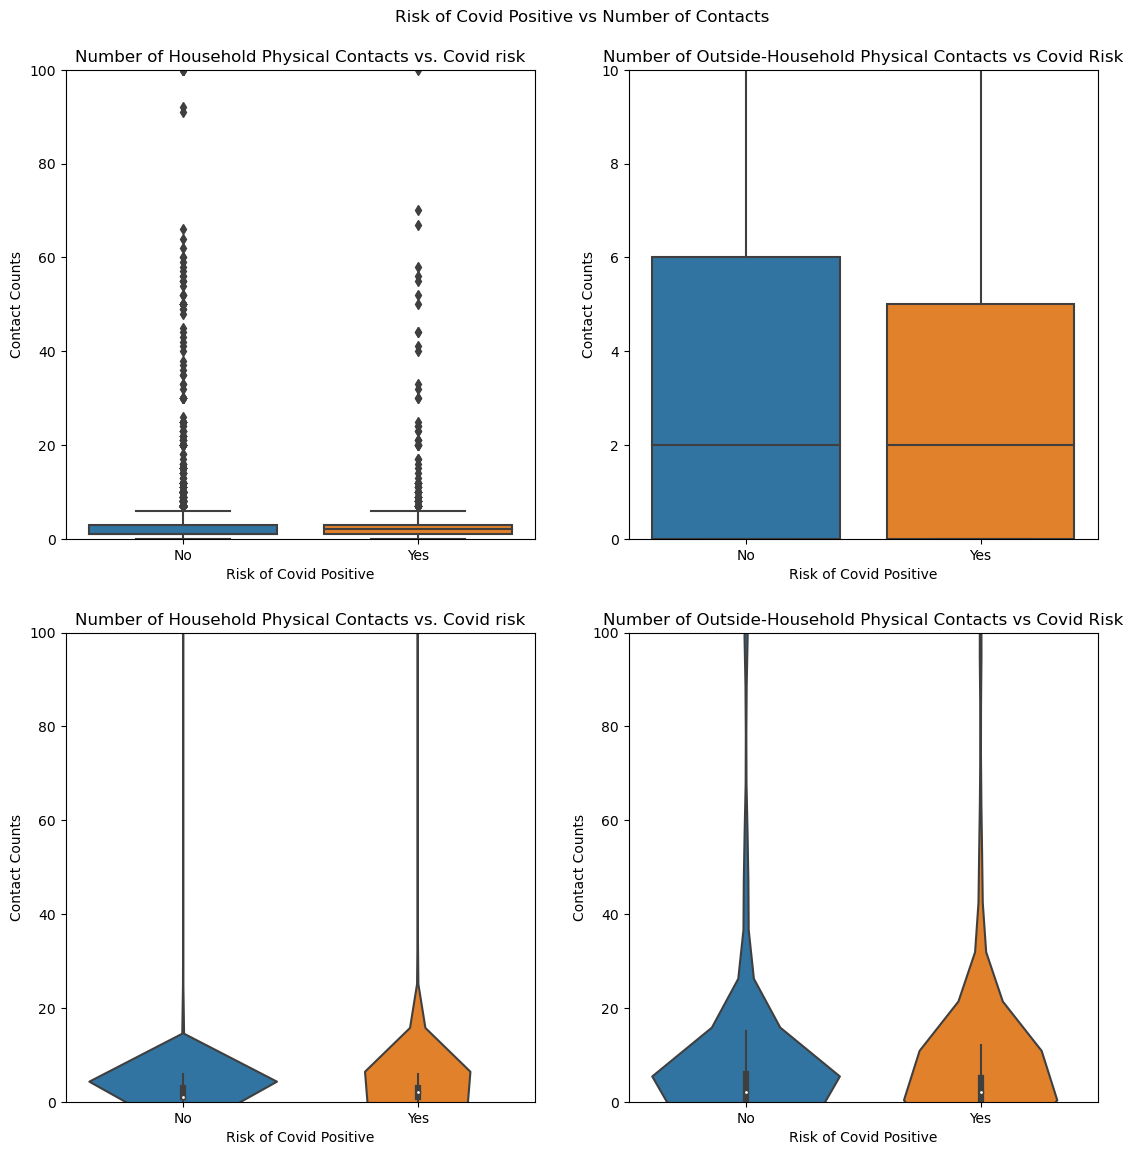

In [192]:
#Box plot between Y and numerical predictors i1 & i2
#violinplot
f, ([ax1, ax2],[ax3, ax4]) = plt.subplots(2, 2, figsize=(12, 12) ,sharey =False)
f.suptitle('Risk of Covid Positive vs Number of Contacts')

sns.boxplot(ax=ax1, y = plot_df["i1_health"], x = plot_df["Risk of Covid Positive"], data = plot_df, orient="v")
ax1.set_title('Number of Household Physical Contacts vs. Covid risk')
ax1.set_ylabel('Contact Counts')
ax1.set_ylim(0, 100)

sns.boxplot(ax=ax2, y = plot_df["i2_health"], x = plot_df["Risk of Covid Positive"], data = plot_df) # change to new target variable
ax2.set_title('Number of Outside-Household Physical Contacts vs Covid Risk')
ax2.set_ylabel('Contact Counts')
ax2.set_ylim(0, 10)
plt.subplots_adjust(left=0.07, bottom=0.07, right=0.93, top=0.93)

sns.violinplot(ax=ax3, y = plot_df["i1_health"], x = plot_df["Risk of Covid Positive"], data = plot_df, orient="v")
ax3.set_title('Number of Household Physical Contacts vs. Covid risk')
ax3.set_ylabel('Contact Counts')
ax3.set_ylim(0, 100)

sns.violinplot(ax=ax4, y = plot_df["i2_health"], x = plot_df["Risk of Covid Positive"], data = plot_df) # change to new target variable
ax4.set_title('Number of Outside-Household Physical Contacts vs Covid Risk')
ax4.set_ylabel('Contact Counts')
ax4.set_ylim(0, 100)
plt.subplots_adjust(left=0.07, bottom=0.07, right=0.93, top=0.93)

plt.show()
#plt.savefig('i1 + i2.png', dpi=300)


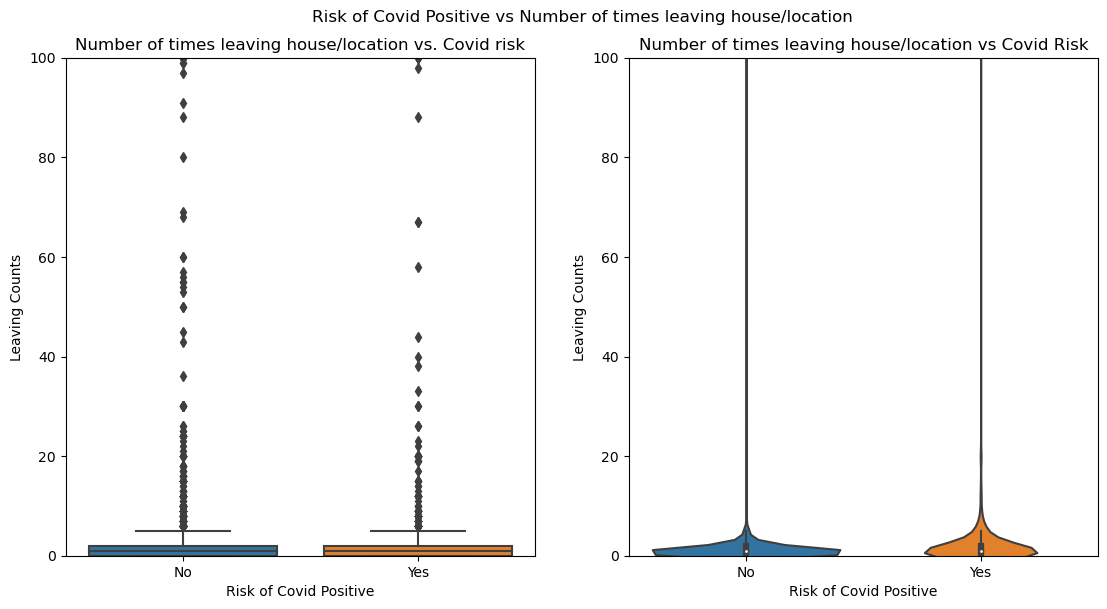

In [193]:
#Box plot between Y and numerical predictors i7a
#violinplot
f, ([ax1, ax2]) = plt.subplots(1,2, figsize=(12, 6) ,sharey =False)
f.suptitle('Risk of Covid Positive vs Number of times leaving house/location')

sns.boxplot(ax=ax1, y = plot_df["i7a_health"], x = plot_df["Risk of Covid Positive"], data = plot_df, orient="v")
ax1.set_title('Number of times leaving house/location vs. Covid risk')
ax1.set_ylabel('Leaving Counts')
ax1.set_ylim(0, 100)

sns.violinplot(ax=ax2, y = plot_df["i7a_health"], x = plot_df["Risk of Covid Positive"], data = plot_df) # change to new target variable
ax2.set_title('Number of times leaving house/location vs Covid Risk')
ax2.set_ylabel('Leaving Counts')
ax2.set_ylim(0, 100)
plt.subplots_adjust(left=0.07, bottom=0.07, right=0.93, top=0.9)

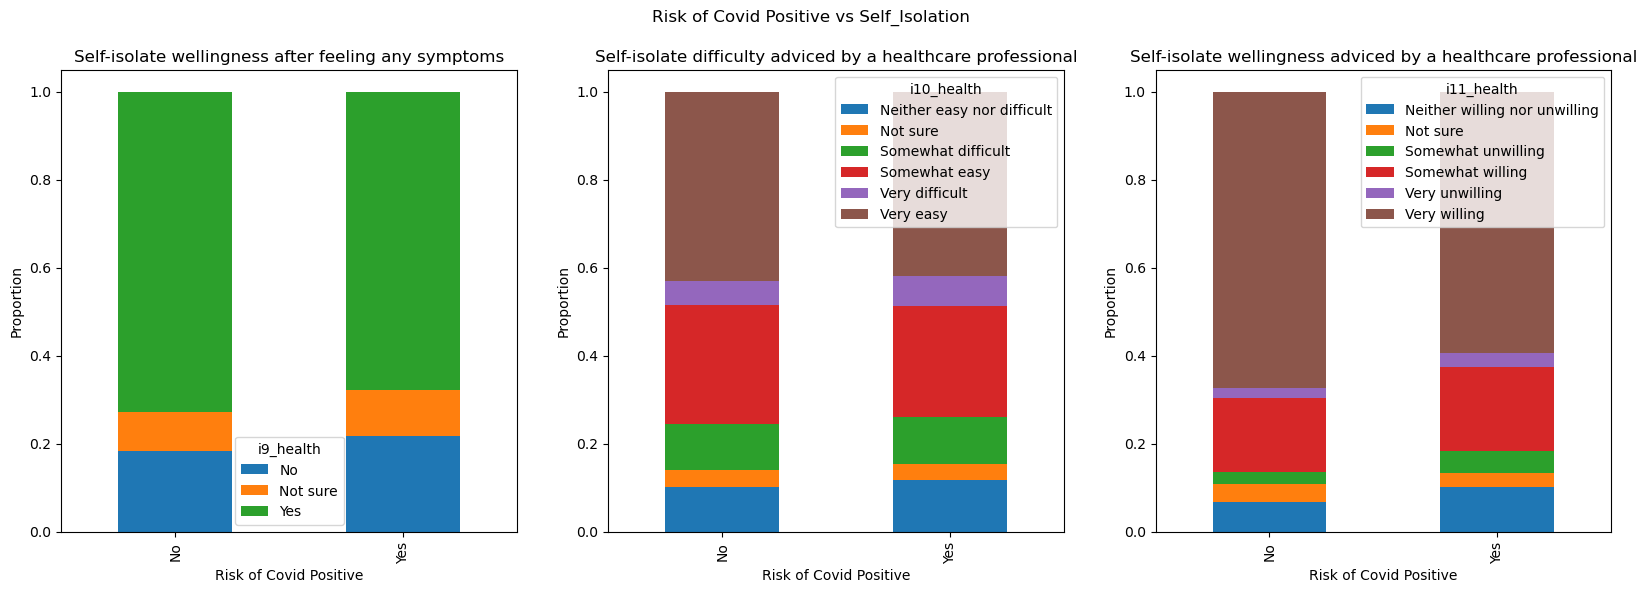

In [194]:
f, ([ax1, ax2, ax3]) = plt.subplots(1,3, figsize=(20, 6) ,sharey =False)
f.suptitle('Risk of Covid Positive vs Self_Isolation')
pd.crosstab(plot_df["Risk of Covid Positive"], plot_df["i9_health"], normalize = 'index').plot(ax = ax1, kind='bar', stacked=True)
ax1.set_title('Self-isolate wellingness after feeling any symptoms')
ax1.set_ylabel('Proportion')

pd.crosstab(plot_df["Risk of Covid Positive"], plot_df["i10_health"], normalize = 'index').plot(ax = ax2, kind='bar', stacked=True)
ax2.set_title('Self-isolate difficulty adviced by a healthcare professional')
ax2.set_ylabel('Proportion')

pd.crosstab(plot_df["Risk of Covid Positive"], plot_df["i11_health"], normalize = 'index').plot(ax = ax3, kind='bar', stacked=True)
ax3.set_title('Self-isolate wellingness adviced by a healthcare professional')
ax3.set_ylabel('Proportion')

plt.show()

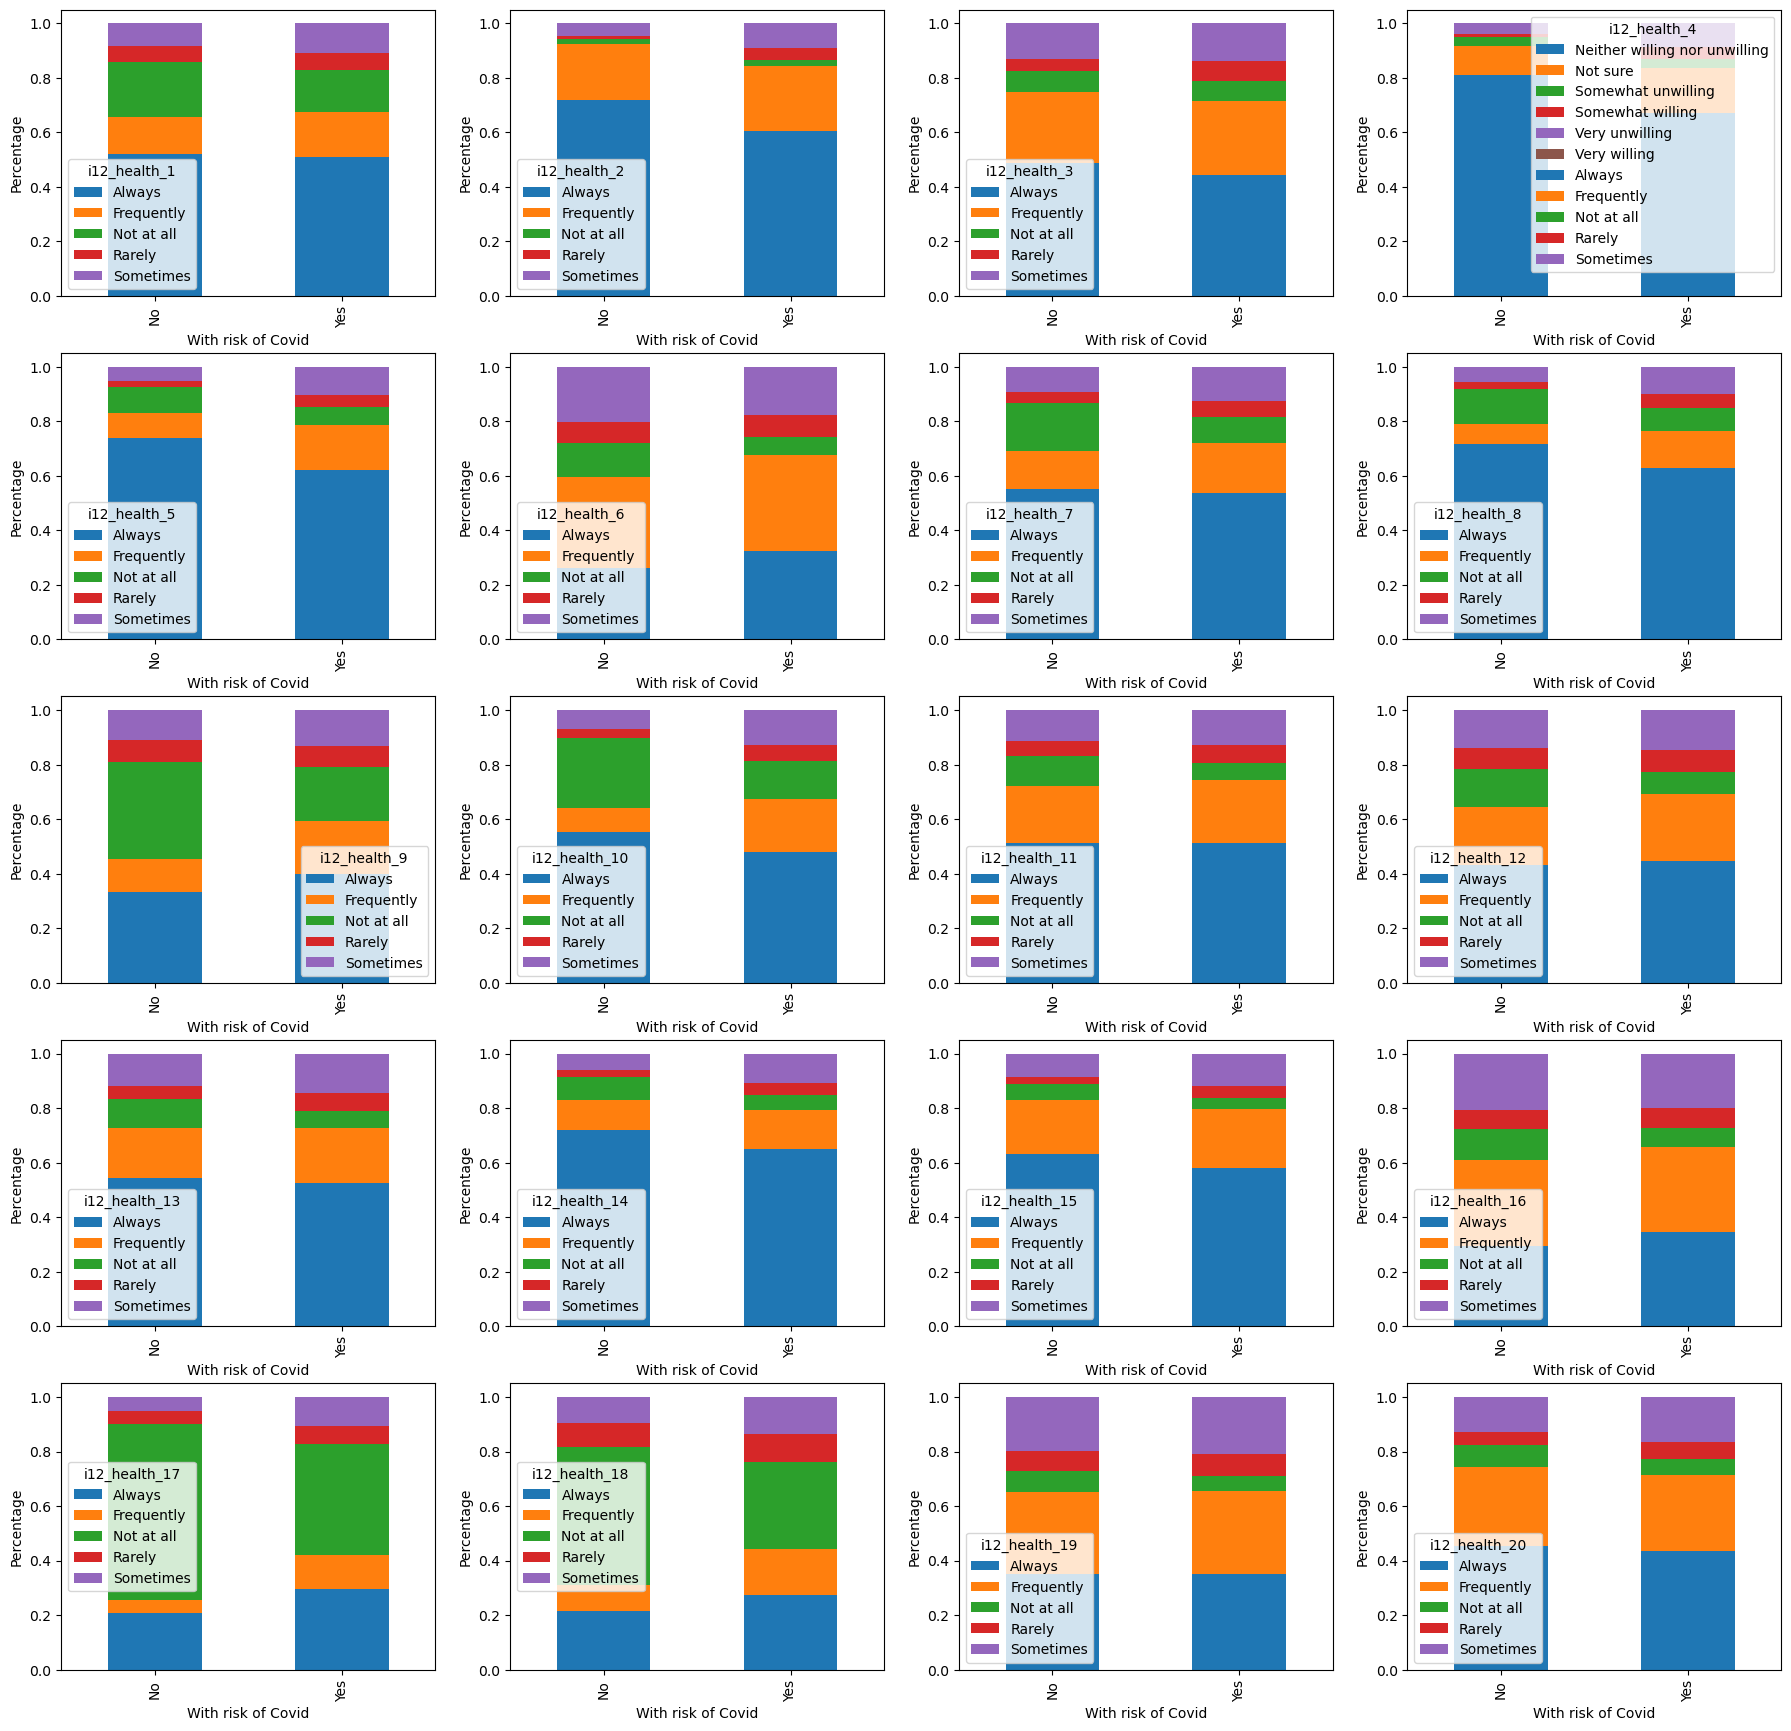

In [195]:
xmax = 4
ymax = 5
f, axes = plt.subplots(ymax,xmax, figsize=(20, 20) ,sharey =False)
i12_df = plot_df.iloc[:,5:26]
x = -1
y = 0

for col in i12_df. columns. values:
  if x >= xmax:
    y += 1
    x = 0
  pd.crosstab(plot_df["Risk of Covid Positive"], plot_df[col], normalize = 'index').plot(ax = (axes[y, x]), kind='bar', stacked=True)
  axes[y, x].set_ylabel("Percentage")
  axes[y, x].set_xlabel("With risk of Covid")
  x += 1
plt.subplots_adjust(left=0.07, bottom=0.07, right=0.93, top=0.9)
plt.show()

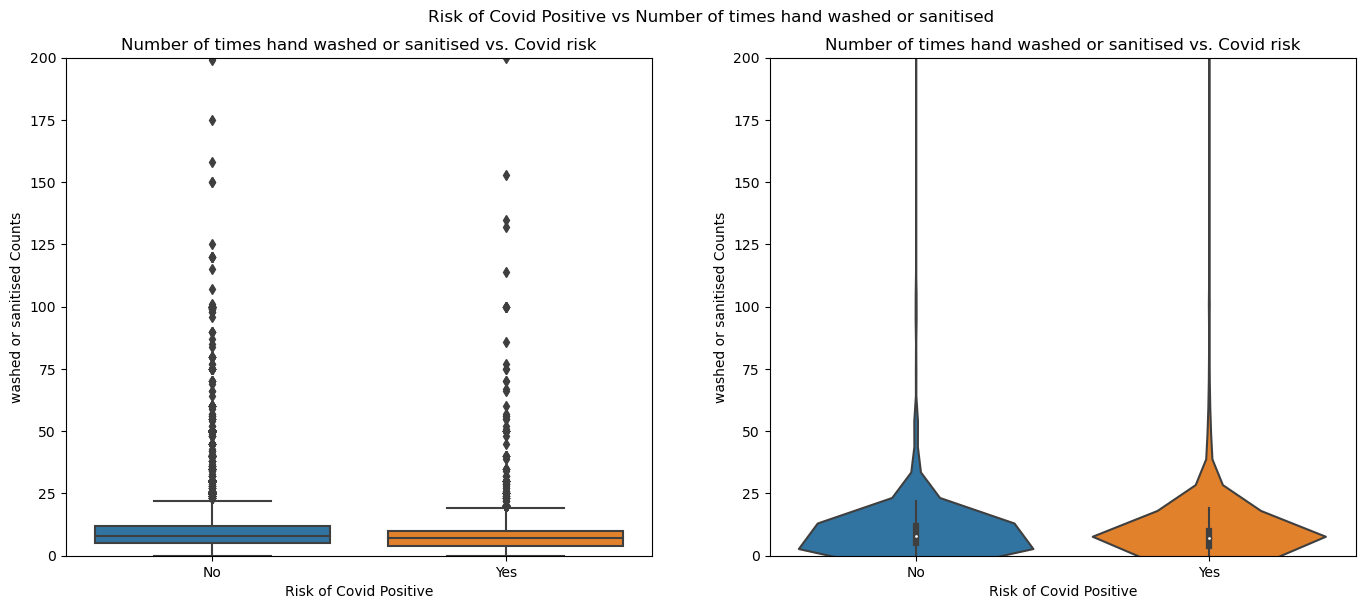

In [196]:
#Box plot between Y and numerical predictors i13
#violinplot
f, ([ax1, ax2]) = plt.subplots(1,2, figsize=(15, 6) ,sharey =False)
f.suptitle('Risk of Covid Positive vs Number of times hand washed or sanitised')

sns.boxplot(ax=ax1, y = plot_df["i13_health"], x = plot_df["Risk of Covid Positive"], data = plot_df, orient="v")
ax1.set_title('Number of times hand washed or sanitised vs. Covid risk')
ax1.set_ylabel('washed or sanitised Counts')
ax1.set_ylim(0, 200)

sns.violinplot(ax=ax2, y = plot_df["i13_health"], x = plot_df["Risk of Covid Positive"], data = plot_df) 
ax2.set_title('Number of times hand washed or sanitised vs. Covid risk')
ax2.set_ylabel('washed or sanitised Counts')
ax2.set_ylim(0, 200)
plt.subplots_adjust(left=0.07, bottom=0.07, right=0.93, top=0.9)

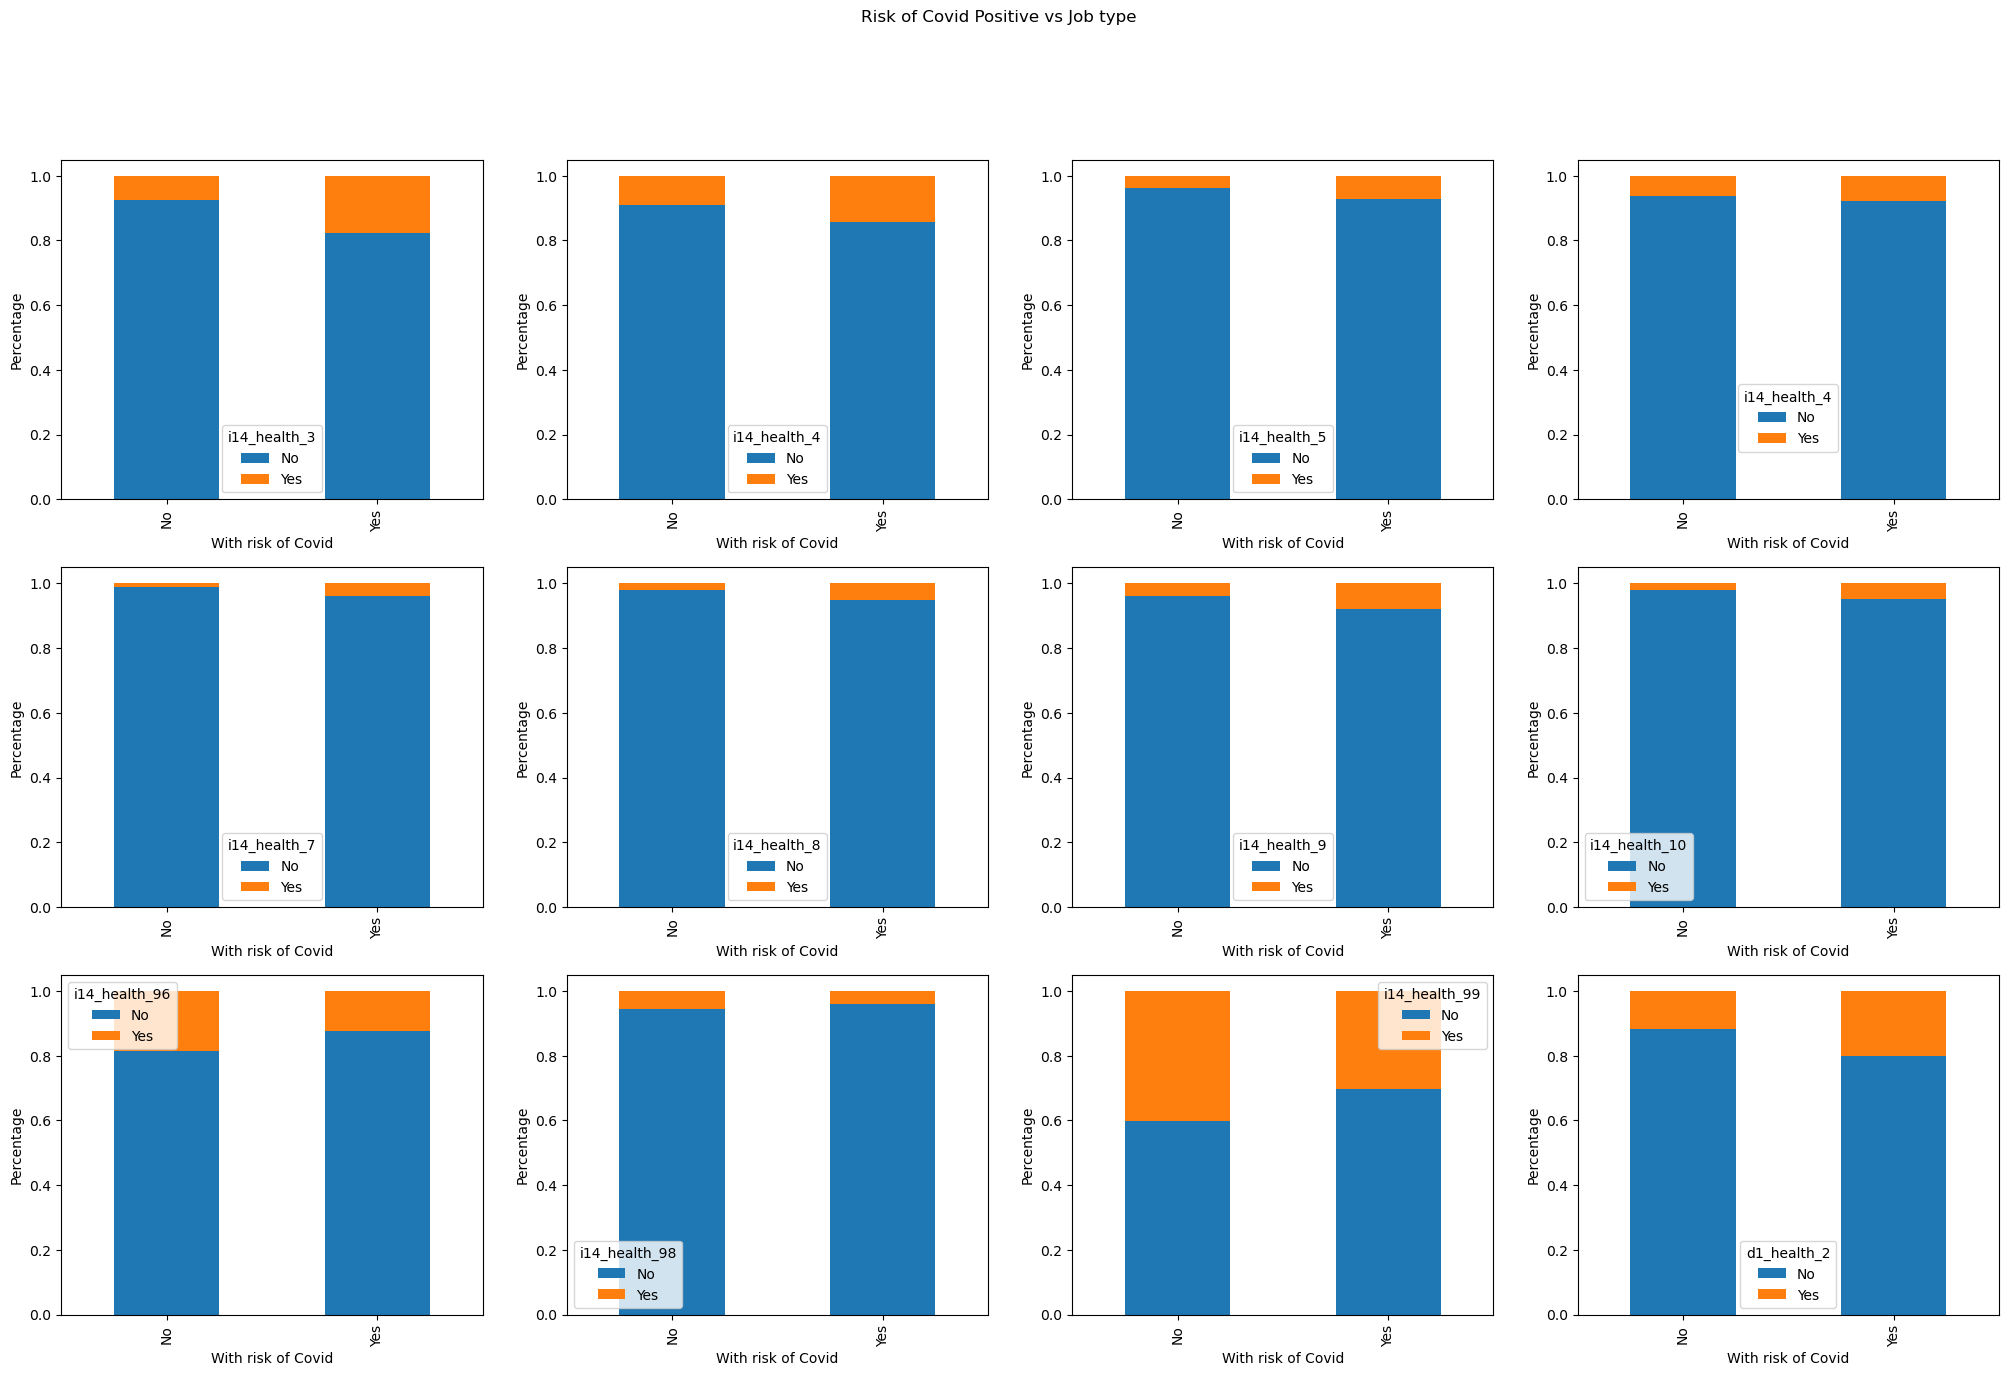

In [197]:
xmax = 4
ymax = 3
f, axes = plt.subplots(ymax,xmax, figsize=(25, 15) ,sharey =False)
i14_df = plot_df.iloc[:,np.r_[28:32,32:40,41:42]]
f.suptitle('Risk of Covid Positive vs Job type')


x = -1
y = 0
for col in i14_df. columns. values:
  if x >= xmax:
    y += 1
    x = 0

  pd.crosstab(plot_df["Risk of Covid Positive"], plot_df[col], normalize = 'index').plot(ax = (axes[y, x]), kind='bar', stacked=True)
  #plt.title('Self-isolate inititive after feeling any symptoms')
  axes[y, x].set_ylabel("Percentage")
  axes[y, x].set_xlabel("With risk of Covid")
  x += 1
axes[0, 3].legend(['No', 'Yes'],title='i14_health_4',bbox_to_anchor=(0.5, 0.12)) 
plt.show()


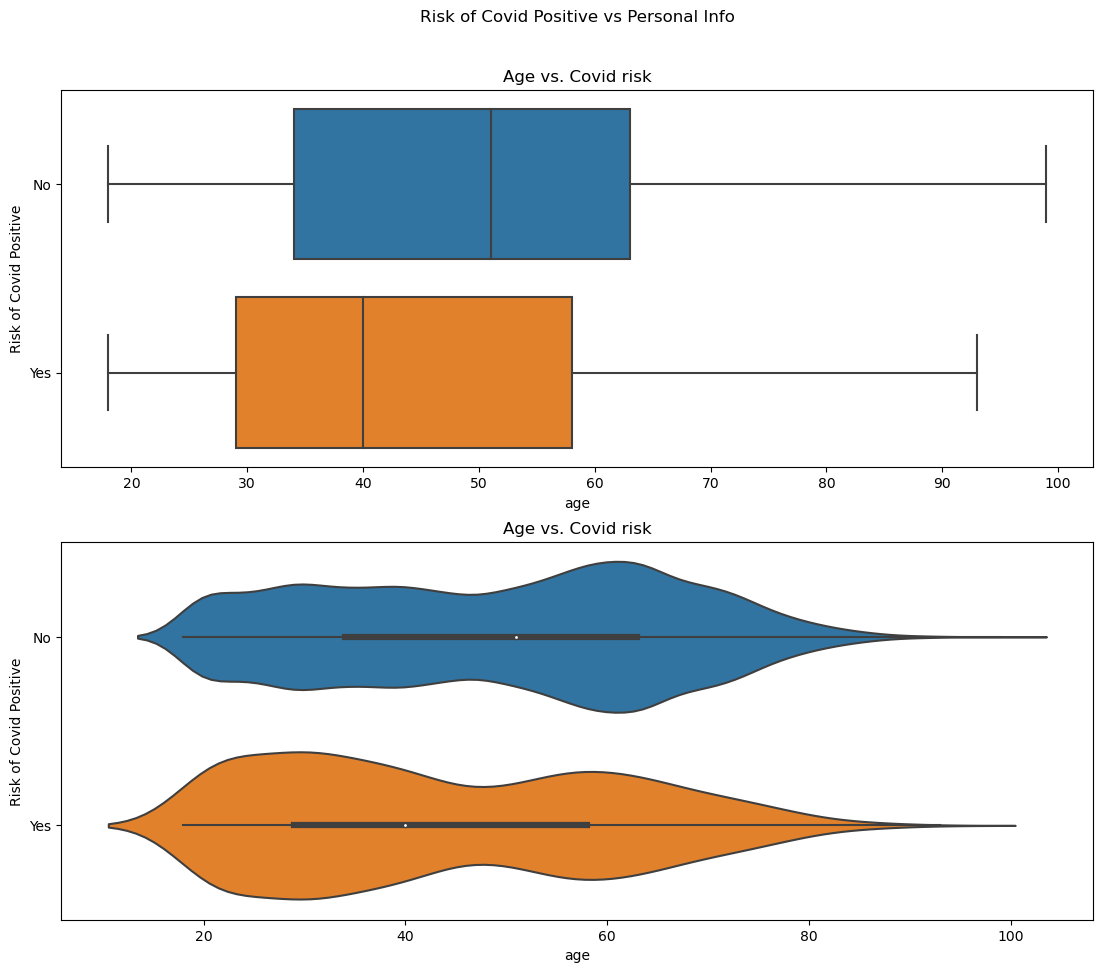

In [198]:
f, ([ax1, ax2]) = plt.subplots(2,1, figsize=(12, 10) ,sharey =False)
f.suptitle('Risk of Covid Positive vs Personal Info')

sns.boxplot(ax=ax1, y = plot_df["Risk of Covid Positive"], x = plot_df["age"], data = plot_df, orient="h")
ax1.set_title('Age vs. Covid risk')
ax1.set_ylabel('Risk of Covid Positive')

sns.violinplot(ax=ax2, y = plot_df["Risk of Covid Positive"], x = plot_df["age"], data = plot_df)
ax2.set_title('Age vs. Covid risk')
ax2.set_ylabel('Risk of Covid Positive')
plt.subplots_adjust(left=0.07, bottom=0.07, right=0.93, top=0.9)
plt.show()


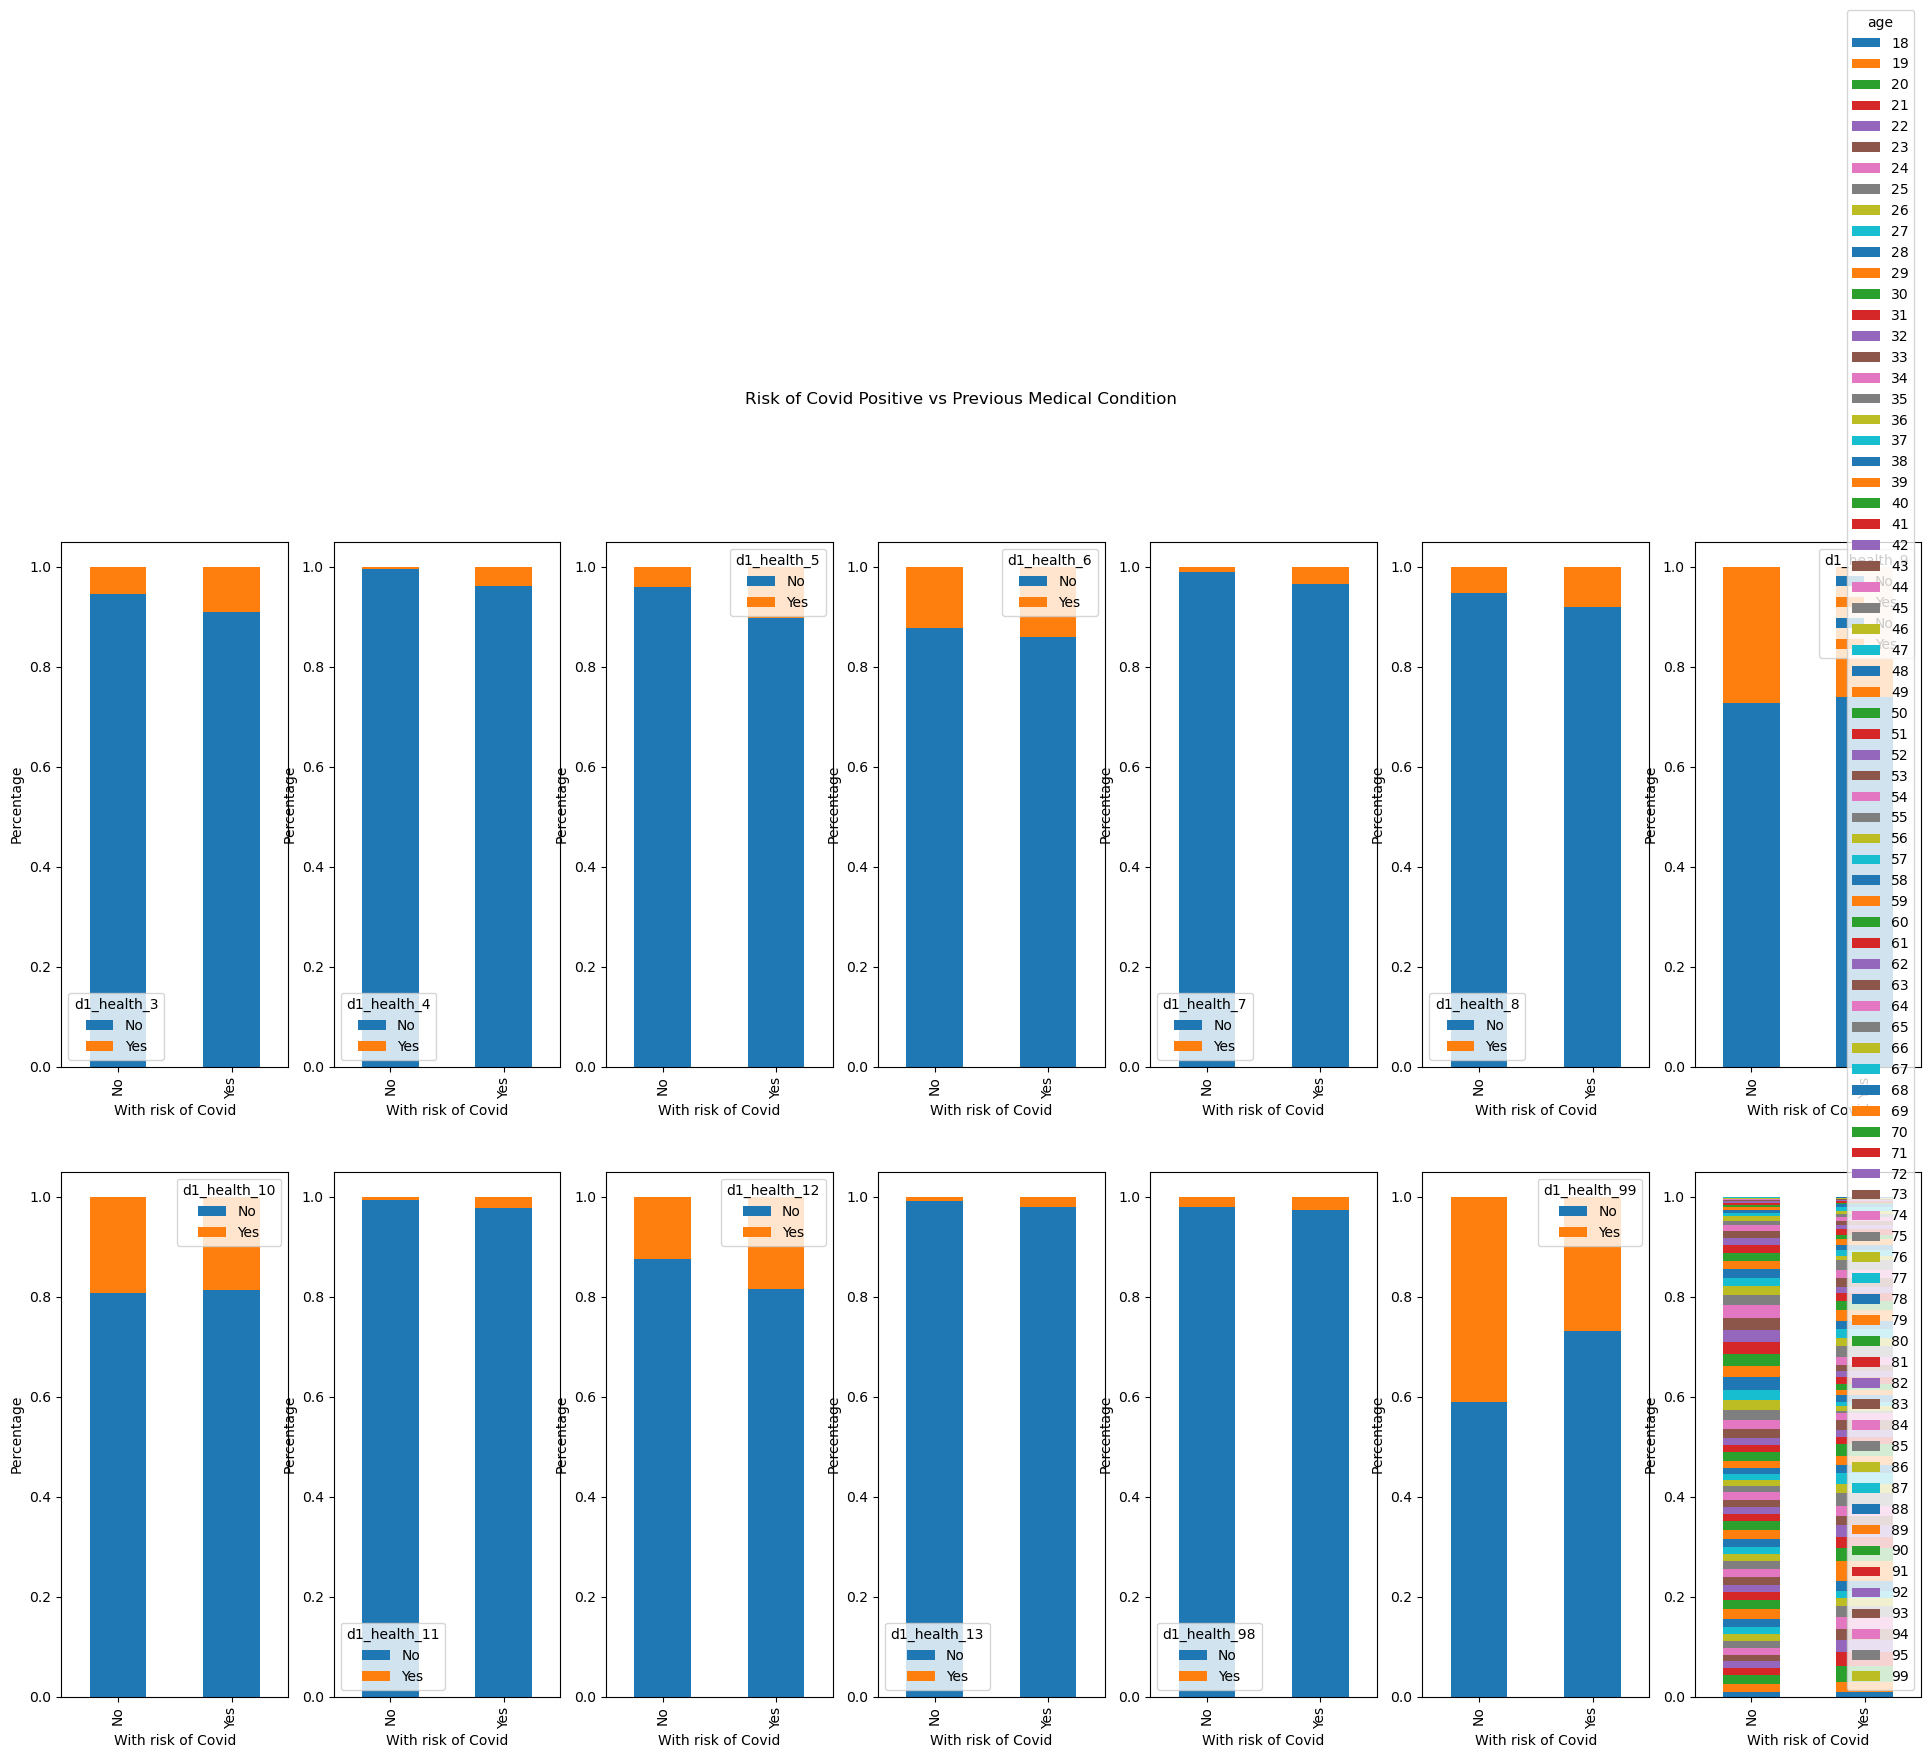

In [199]:
xmax = 7
ymax = 2
f, axes = plt.subplots(ymax,xmax, figsize=(24, 15) ,sharey =False)
d1_df = plot_df.iloc[:,np.r_[41:55,56:57 ]]
f.suptitle('Risk of Covid Positive vs Previous Medical Condition')
#
x = -1
y = 0
title = ""
for col in d1_df. columns. values:
  if x >= xmax:
    y += 1
    x = 0
  
  pd.crosstab(plot_df["Risk of Covid Positive"], plot_df[col], normalize = 'index').plot(ax = (axes[y, x]), kind='bar', stacked=True)

  axes[y, x].set_ylabel("Percentage")
  axes[y, x].set_xlabel("With risk of Covid")
  x += 1

# bug hardcode
#axes[0, 3].legend(['No', 'Yes'],title='i14_health_4', bbox_to_anchor=[0.5, 0.12], loc='center') 
plt.show()


Text(0.5, 0, 'With risk of Covid')

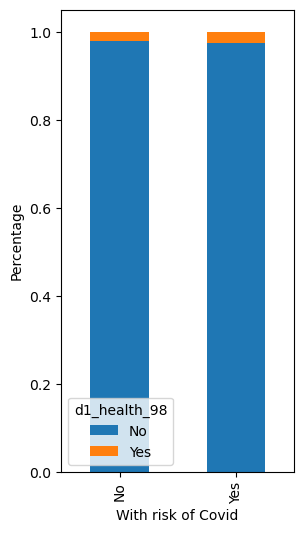

In [200]:
pd.crosstab(plot_df["Risk of Covid Positive"], plot_df['d1_health_98'], normalize = 'index').plot(kind='bar', stacked=True, figsize=(3,6) )

plt.ylabel("Percentage")
plt.xlabel("With risk of Covid")

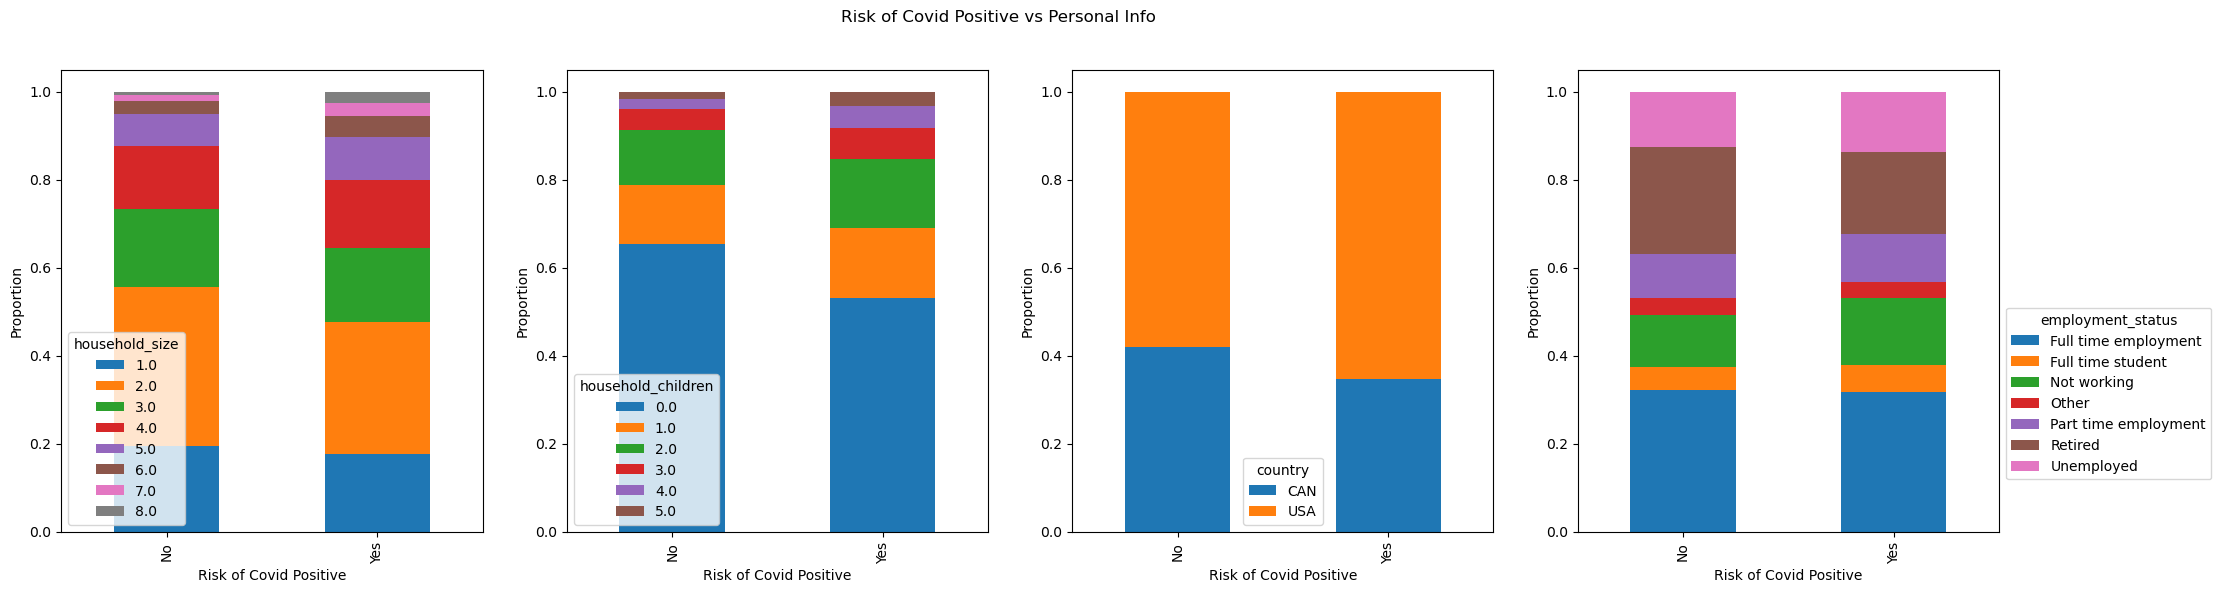

In [201]:
f, ([ax1, ax2, ax3, ax4]) = plt.subplots(1,4, figsize=(25, 6) ,sharey =False)
f.suptitle('Risk of Covid Positive vs Personal Info')
pd.crosstab(plot_df["Risk of Covid Positive"], plot_df["household_size"], normalize = 'index').plot(ax = ax1, kind='bar', stacked=True)
ax1.set_ylabel('Proportion')

pd.crosstab(plot_df["Risk of Covid Positive"], plot_df["household_children"], normalize = 'index').plot(ax = ax2, kind='bar', stacked=True)
ax2.set_ylabel('Proportion')

pd.crosstab(plot_df["Risk of Covid Positive"], plot_df["employment_status"], normalize = 'index').plot(ax = ax4, kind='bar', stacked=True)
ax4.set_ylabel('Proportion')

pd.crosstab(plot_df["Risk of Covid Positive"], plot_df["country"], normalize = 'index').plot(ax = ax3, kind='bar', stacked=True)
ax3.set_ylabel('Proportion')

ax4.legend(title='employment_status',bbox_to_anchor=(1, 0.5)) 

plt.show()

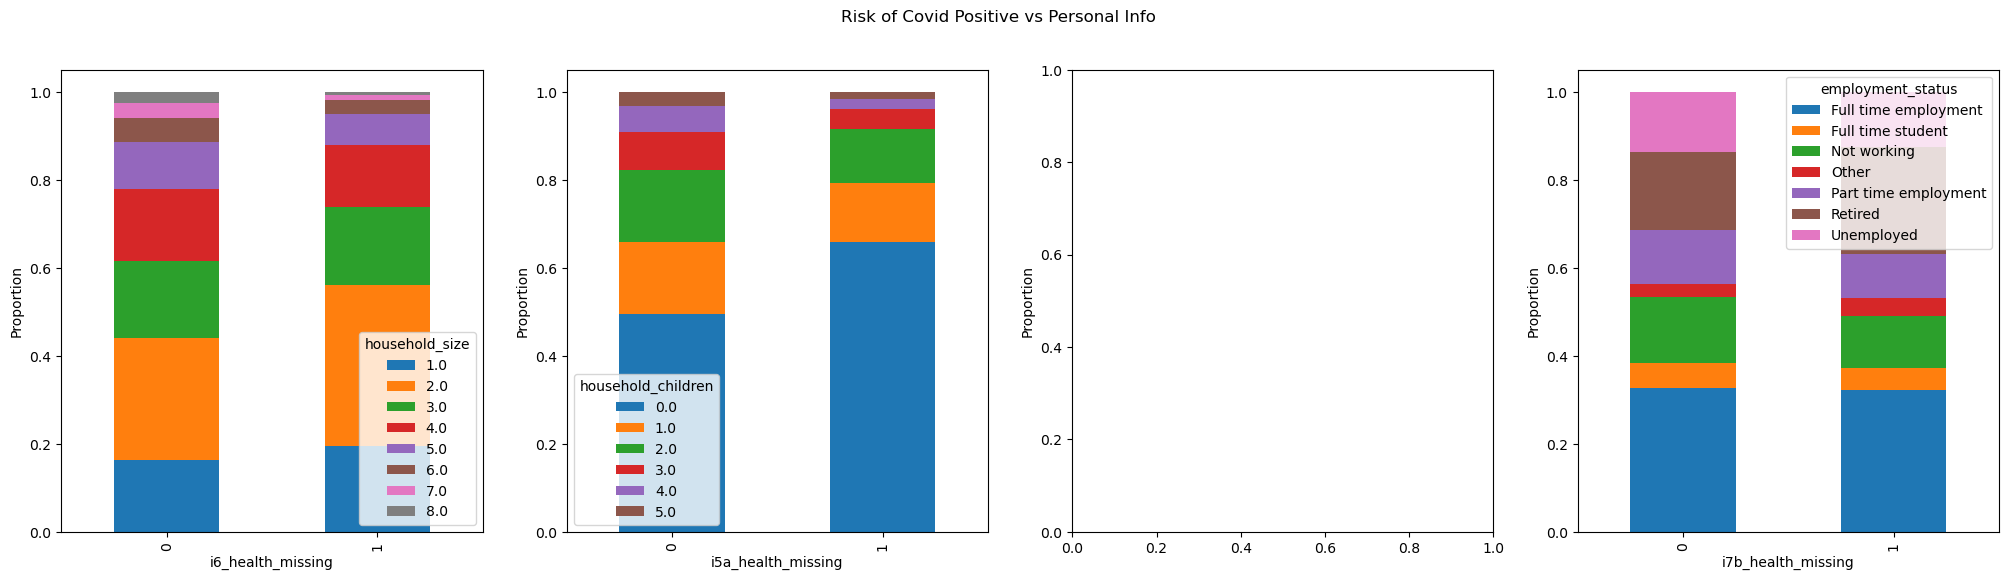

In [202]:
f, ([ax1, ax2, ax3, ax4]) = plt.subplots(1,4, figsize=(25, 6) ,sharey =False)
f.suptitle('Risk of Covid Positive vs Personal Info')
pd.crosstab(plot_df["i6_health_missing"], plot_df["household_size"], normalize = 'index').plot(ax = ax1, kind='bar', stacked=True)
ax1.set_ylabel('Proportion')

pd.crosstab(plot_df["i5a_health_missing"], plot_df["household_children"], normalize = 'index').plot(ax = ax2, kind='bar', stacked=True)
ax2.set_ylabel('Proportion')

pd.crosstab(plot_df["i7b_health_missing"], plot_df["employment_status"], normalize = 'index').plot(ax = ax4, kind='bar', stacked=True)
ax4.set_ylabel('Proportion')

ax3.set_ylabel('Proportion')

#ax4.legend(title='employment_status',bbox_to_anchor=(1, 0.5)) 

plt.show()

<AxesSubplot:xlabel='household_size', ylabel='employment_status'>

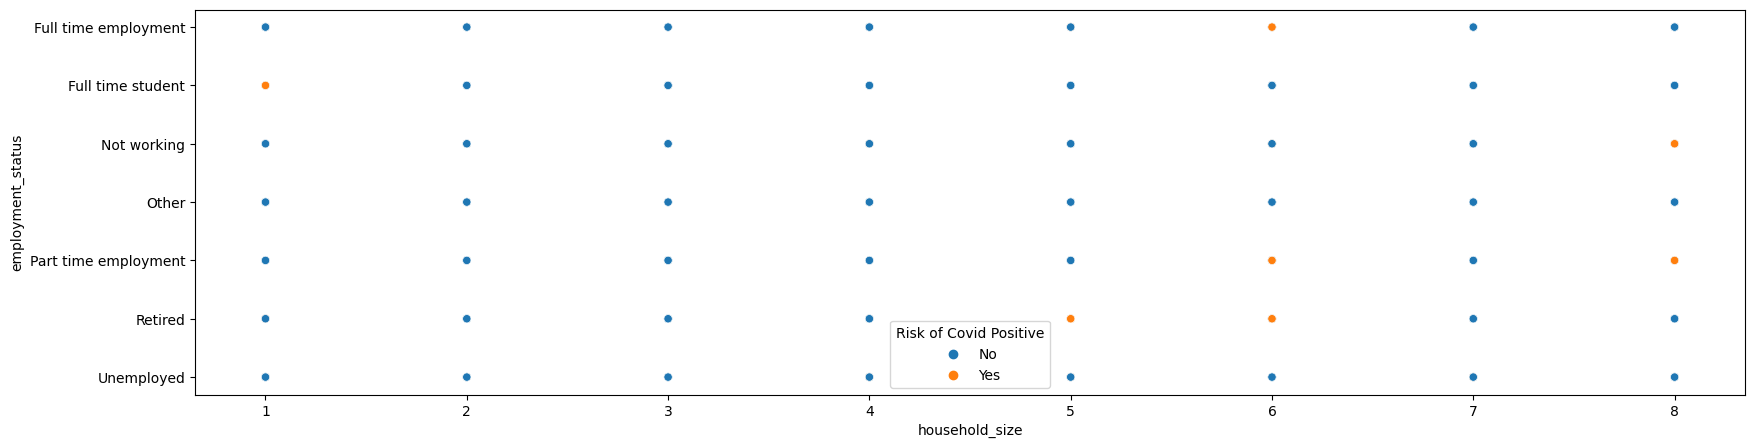

In [203]:
sns.scatterplot(x = "household_size", y = "employment_status", hue = "Risk of Covid Positive", data = plot_df)

In [205]:
# a few columns indicating missingness are highly correlated with our target variable
X_train.corrwith(y_train).sort_values()

i5a_health_missing   -0.890496
i6_health_missing    -0.890496
i7b_health_missing   -0.841016
i8_health_missing    -0.827065
age                  -0.088667
                        ...   
i14_health_3          0.085882
i12_health_18         0.093093
i12_health_17         0.108705
i14_health_2          0.112947
d1_health_4           0.127178
Length: 62, dtype: float64

## drop the highly correlated columns

In [206]:
target_variable = 'covid'
highly_correlated_columns = ['i8_health_missing', 'i7b_health_missing', 'i5a_health_missing', 'i6_health_missing']
X_train = train_set.drop(columns = [target_variable] + highly_correlated_columns).reset_index(drop = True).copy(deep = True)
y_train = train_set[target_variable].reset_index(drop=True)
X_test = test_set.drop(columns = [target_variable] + highly_correlated_columns).reset_index(drop = True).copy(deep = True)
y_test = test_set[target_variable].reset_index(drop=True)

# Modeling

In [207]:
clf = Pipeline(
    data_preparation.steps + [('knn', KNeighborsClassifier())]
    ).fit(X_train, y_train)

with parallel_backend('threading',n_jobs=-1):    
# cross validation score
  AP_CV = cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'average_precision')

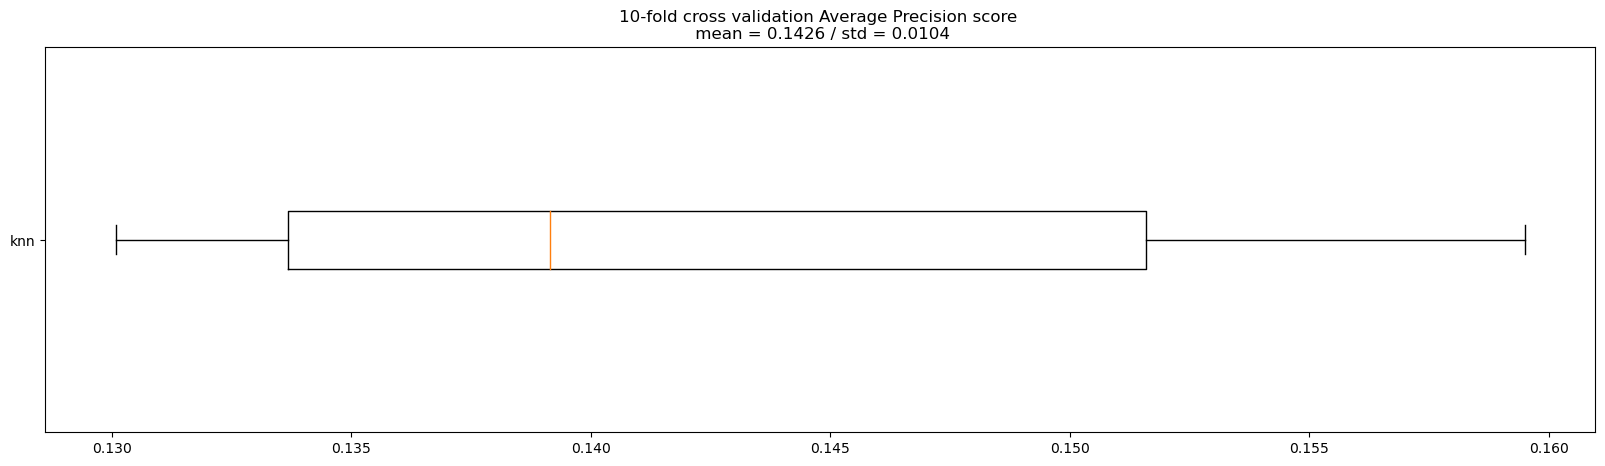

In [208]:
plt.boxplot(AP_CV, labels=["knn"], vert = False)
plt.title(f"10-fold cross validation Average Precision score \n mean = {np.mean(AP_CV):0.4f} / std = {np.std(AP_CV):0.4f}")
plt.show()

Tune the model. 
Carefully consider all points that we discussed in class with respect to k-NN. 


In [209]:
param_grids = {
    "knn": {
        "knn__n_neighbors": np.arange(800,1300,1),
        "knn__metric": ['cosine', 'l1', 'l2'],
        "knn__weights": ['uniform', 'distance'],
    }
}

In [210]:
# tune hyperparameters with RandomizedSearchCV
from timeit import default_timer as timer

current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
clf_name = 'knn'
full_pipeline = Pipeline(
      data_preparation.steps + [(clf_name, KNeighborsClassifier())]
      )

param_grid = copy.deepcopy(param_grids[clf_name])
with parallel_backend('threading', n_jobs=-1):
  random_search = RandomizedSearchCV(full_pipeline,
                                   param_grid, 
                                   cv = 10, 
                                   n_iter = 5,
                                   random_state = 42,
                                   scoring = "average_precision",
                                   # n_jobs = -1,
                                   error_score = 'raise')
random_search.fit(X_train, y_train)

print(pd.DataFrame(random_search.cv_results_).sort_values(['param_' + list(param_grid.keys())[-1]])[['param_' + x for x in list(param_grid.keys())] + ['mean_test_score', 'mean_fit_time', 'std_test_score']].head(5))
print(f"\nbest_score: {random_search.best_score_}")
print(f"best_params: {random_search.best_params_}")

  param_knn__n_neighbors param_knn__metric param_knn__weights  \
3                    847                l1           distance   
0                   1230            cosine            uniform   
1                    947                l1            uniform   
2                    865                l1            uniform   
4                   1119                l1            uniform   

   mean_test_score  mean_fit_time  std_test_score  
3         0.247403       0.141928        0.027154  
0         0.230212       0.145934        0.033492  
1         0.240781       0.143588        0.029149  
2         0.241426       0.144062        0.028134  
4         0.239335       0.146759        0.030061  

best_score: 0.2474029917443307
best_params: {'knn__weights': 'distance', 'knn__n_neighbors': 847, 'knn__metric': 'l1'}


## AUPRC or AP

In [211]:
# CV_model = best_model
cv_result = pd.DataFrame(random_search.cv_results_)
cv_AP_colindex = [i for i, x in enumerate(cv_result.columns.values) if re.search('split\w+_test_score', x) is not None]
best_CV_AP = pd.DataFrame(random_search.cv_results_).iloc[random_search.best_index_,cv_AP_colindex].values

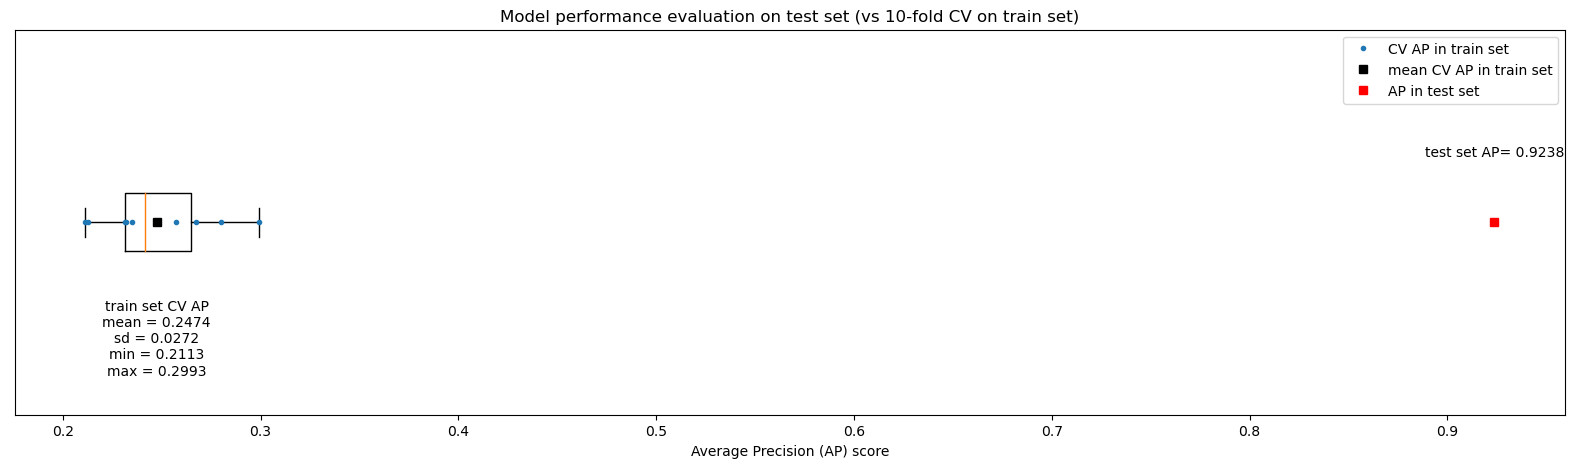

In [212]:
# plot CV AP scores on train set
plt.boxplot(best_CV_AP, labels = [""], vert=False)
plt.plot(best_CV_AP, [1]*len(best_CV_AP), ".", label='CV AP in train set')
plt.annotate(f"train set CV AP\n" + 
             f"mean = {np.mean(best_CV_AP):0.4f}\n" + 
             f"sd = {np.std(best_CV_AP):0.4f}\n" + 
             f"min = {np.min(best_CV_AP):0.4f}\n" + 
             f"max = {np.max(best_CV_AP):0.4f}",
             (np.mean(best_CV_AP), 0.8), 
              ha = 'center', va = 'top')
plt.plot(np.mean(best_CV_AP), [1], "ks", label = 'mean CV AP in train set')

# compare with AP score on test set
y_probs = best_model.predict_proba(X_test)[:,1]
test_AP = average_precision_score(y_test, y_probs)
plt.plot(test_AP, [1], "rs", label = 'AP in test set')
plt.annotate(f"test set AP= {test_AP:0.4f}",(test_AP, 1.2), 
              ha = 'center', va = 'top')

plt.legend()
plt.title(f"Model performance evaluation on test set (vs 10-fold CV on train set)")
plt.xlabel("Average Precision (AP) score")
# plt.xlim(0.5,1)
plt.ylabel("")
plt.yticks([])
plt.show()

## AUROC

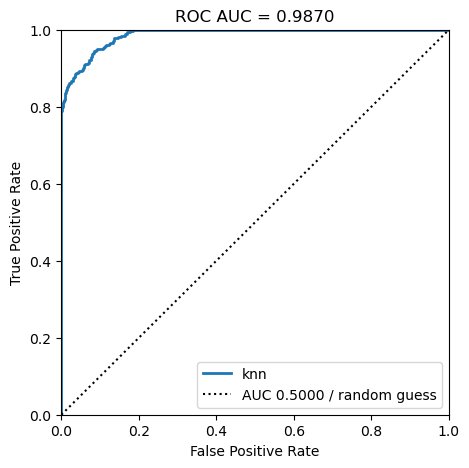

In [213]:
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, linewidth = 2, label = f"{best_model.steps[-1][0]}")
plt.plot([0,1], [0,1], 'k:', label = "AUC 0.5000 / random guess")
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(f"ROC AUC = {roc_auc_score(y_test, y_probs):0.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.show()

## Precision Recall Curve

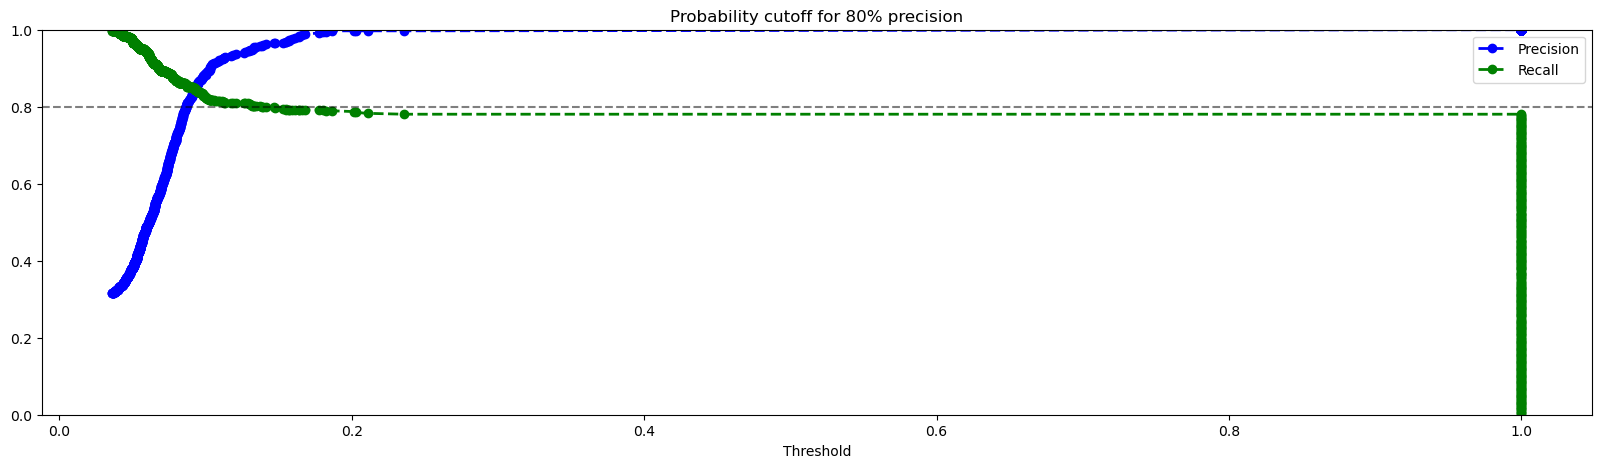

In [214]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
plt.plot(thresholds, precisions[:-1], 'b--o', label = "Precision", linewidth = 2)
plt.plot(thresholds, recalls[:-1], "g--o", label = "Recall", linewidth = 2)
plt.xlabel("Threshold")
plt.ylim(0,1)
plt.axhline(0.8, ls='--', c='k', alpha=0.5)
plt.title("Probability cutoff for 80% precision")
plt.legend()
plt.show()

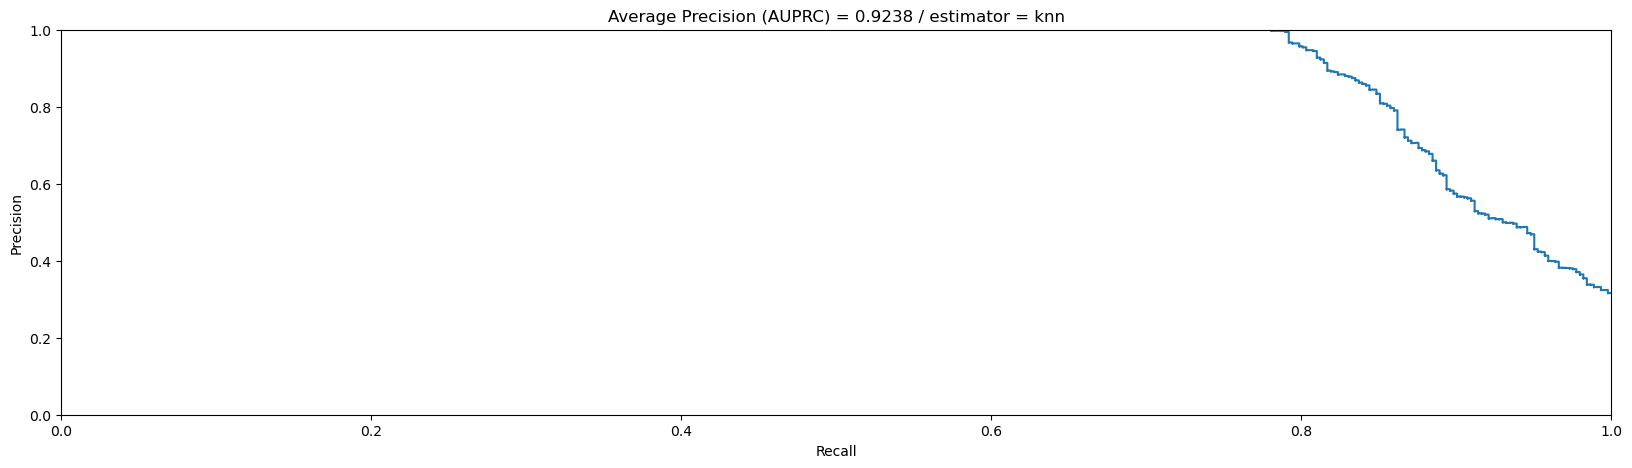

In [215]:
PrecisionRecallDisplay(precision=precisions, recall=recalls).plot()
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(f"Average Precision (AUPRC) = {average_precision_score(y_test, y_probs):0.4f} / estimator = {best_model.steps[-1][0]}")
plt.show()

## Confusion matrix

In [216]:
# to achieve a recall of 80% or more
recall_pct = 0.8

In [217]:
idx_for_chosen_precision = (recalls >= recall_pct).argmin()
chosen_threshold = thresholds[idx_for_chosen_precision]
y_predict = (best_model.predict_proba(X_test)[:,1] >= chosen_threshold)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      5191
         1.0       0.96      0.80      0.87       442

    accuracy                           0.98      5633
   macro avg       0.97      0.90      0.93      5633
weighted avg       0.98      0.98      0.98      5633



In [218]:
# a lot of FN due to class imbalance
confusion_matrix(y_test, y_predict)

array([[5175,   16],
       [  89,  353]], dtype=int64)

In [ ]:
# Thanks to the great help from the team from where I learnt a lot